In this notebook, we will use the Kion Movies Recommendation Dataset (see data source link below) to build a two-tier recommendation model, which consists of a matrix factorization model to select a pool of candidates and a boosting model to do the ranking task. We will use two approaches:

- BPR + CatBoost as a baseline without any complex feature engineering and tuning that shows a decent quality on the test set.

- BPR + ALS + itemKNN + CatBoost as an improved pipeline, which includes using several 1st level models, additional feature engineering and hyperparameter tuning. We show that this improved approach greatly outperforms our baseline.

I've commented out the heaviest cells and saved the trained models so that the whole notebook is reproducible and runs in a reasonable time. The data and the models have to be unpacked from archives.

Alternatively, you can uncomment all of the cells and run the whole notebook from start to finish (which might take up to 8 hours). The final results might vary slightly.

In [1]:
!pip install implicit --quiet catboost --quiet optuna --quiet sentence_transformers --quiet

In [2]:
!python -m spacy download ru_core_news_md --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 MB 9.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import datetime
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import scipy.sparse as sparse

from catboost import CatBoostClassifier
import implicit
from implicit.nearest_neighbours import ItemItemRecommender
from implicit.als import AlternatingLeastSquares

from sentence_transformers import SentenceTransformer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

import optuna
from collections import Counter
import random
from functools import reduce
import gc
import joblib

import warnings
warnings.simplefilter('ignore')

In [4]:
pd.set_option('display.max_columns', None)

Data source:

https://github.com/irsafilo/KION_DATASET/tree/main (you'll need **data_original.zip** file in the **root directory**. Download it, unzip it, and put the three csv files into the data folder. Or you can just unpack the saved archive already present in the data directory.

- interactions with movies and TV series via the KION app
- user data
- item data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
MAIN_PATH = "/content/drive/MyDrive/ML/projects/two-stage/"
DATA_PATH = "/content/drive/MyDrive/ML/projects/two-stage/data/"

In [7]:
interactions = pd.read_csv(f"{DATA_PATH}interactions.csv")
items = pd.read_csv(f"{DATA_PATH}items.csv")
users = pd.read_csv(f"{DATA_PATH}users.csv")

# EDA

In this section, we will take a look at the datasets and conduct some basic EDA

## `interactions`: user–item interactions
- `last_watch_dt` date of viewing
- `total_dur` viewing duration
- `watched_pct` percentage watched (%)

In [8]:
interactions.head()

user_id  item_id last_watch_dt  total_dur  watched_pct
0   176549     9506    2021-05-11       4250         72.0
1   699317     1659    2021-05-29       8317        100.0
2   656683     7107    2021-05-09         10          0.0
3   864613     7638    2021-07-05      14483        100.0
4   964868     9506    2021-04-30       6725        100.0

In [9]:
interactions['last_watch_dt']

0          2021-05-11
1          2021-05-29
2          2021-05-09
3          2021-07-05
4          2021-04-30
              ...    
5476246    2021-08-13
5476247    2021-04-13
5476248    2021-08-20
5476249    2021-04-19
5476250    2021-08-15
Name: last_watch_dt, Length: 5476251, dtype: object

In [10]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt'], format="%Y-%m-%d", errors='coerce')

print(f"Num of unique users in interactions: {interactions['user_id'].nunique()}")
print(f"Num of unique items in interactions: {interactions['item_id'].nunique()}")

Num of unique users in interactions: 962179
Num of unique items in interactions: 15706


In [11]:
interactions['last_watch_dt'].isna().sum()

np.int64(0)

In [12]:
interactions.dropna(subset=['last_watch_dt'], inplace=True)
interactions.reset_index(drop=True, inplace=True)

In [13]:
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()

print(f"min date in interactions: {min_date}")
print(f"max date in interactions: {max_date}")

min date in interactions: 2021-03-13 00:00:00
max date in interactions: 2021-08-22 00:00:00


## `users`: user data

- `age`: age bin
- `income`: income bin
- `sex`: gender
- `kids_flg`: user has children flag

In [14]:
users.head()

user_id        age        income sex  kids_flg
0   973171  age_25_34  income_60_90   М         1
1   962099  age_18_24  income_20_40   М         0
2  1047345  age_45_54  income_40_60   Ж         0
3   721985  age_45_54  income_20_40   Ж         0
4   704055  age_35_44  income_60_90   Ж         0

In [15]:
users.isna().sum()

user_id         0
age         14095
income      14776
sex         13831
kids_flg        0
dtype: int64

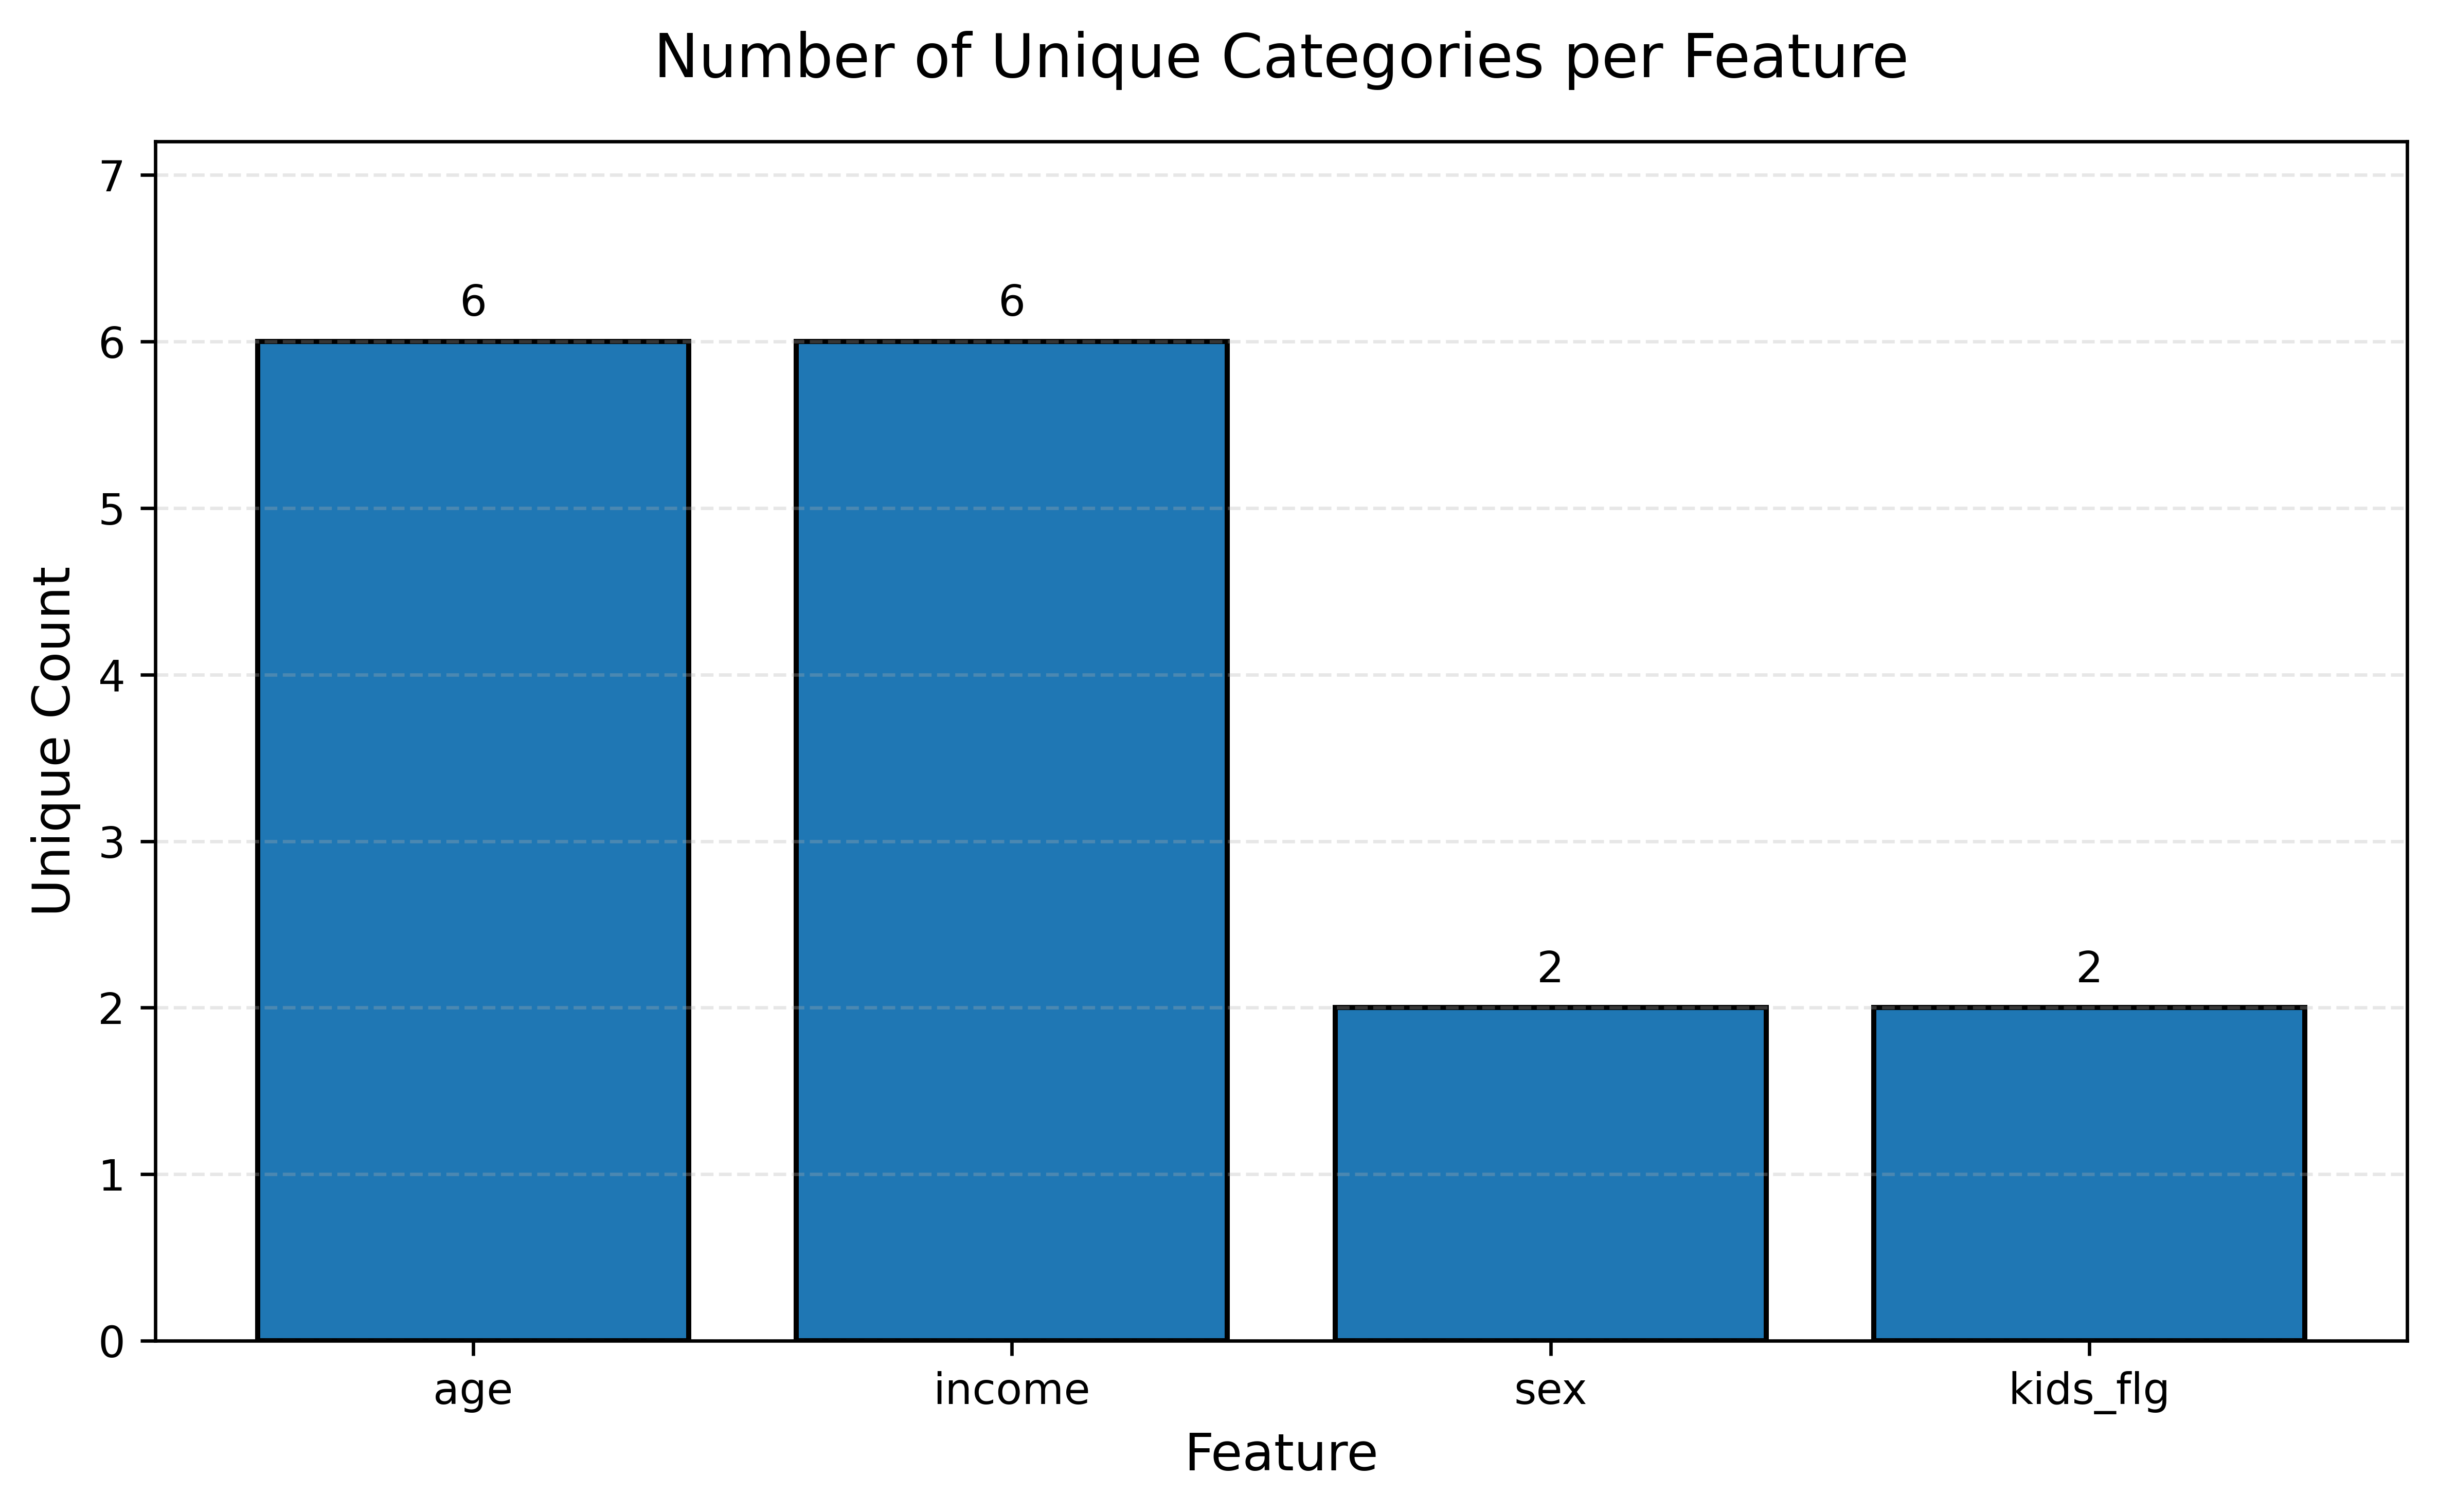

In [16]:
features = ['age', 'income', 'sex', 'kids_flg']
unique_counts = {feat: users[feat].nunique() for feat in features}

labels = list(unique_counts.keys())
counts = list(unique_counts.values())

plt.rcParams['figure.dpi'] = 600
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, edgecolor='black', linewidth=1.2)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height + 0.1,
             f'{int(height)}',
             ha='center', va='bottom')

plt.title('Number of Unique Categories per Feature', fontsize=14, pad=15)
plt.ylabel('Unique Count', fontsize=12)
plt.xlabel('Feature', fontsize=12)
plt.ylim(0, max(counts) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
print(f"Num of unique users in users: {users['user_id'].nunique()}")

Num of unique users in users: 840197


## `items`: item data

- `content_type`: content type
- `title`: title in Russian
- `title_orig`: original title
- `release_year`: release year
- `countries`: countries
- `for_kids`: content-for-kids flag
- `age_rating`: age rating
- `studios`: studios
- `directors`: directors
- `actors`: actors
- `keywords`: keywords
- `description`: description

In [18]:
items.head(3)

item_id content_type             title      title_orig  release_year  \
0    10711         film    Поговори с ней  Hable con ella        2002.0   
1     2508         film       Голые перцы    Search Party        2014.0   
2    10716         film  Тактическая сила  Tactical Force        2011.0   

                                             genres countries  for_kids  \
0           драмы, зарубежные, детективы, мелодрамы   Испания       NaN   
1                  зарубежные, приключения, комедии       США       NaN   
2  криминал, зарубежные, триллеры, боевики, комедии    Канада       NaN   

   age_rating studios         directors  \
0        16.0     NaN  Педро Альмодовар   
1        16.0     NaN    Скот Армстронг   
2        16.0     NaN  Адам П. Калтраро   

                                              actors  \
0  Адольфо Фернандес, Ана Фернандес, Дарио Гранди...   
1  Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...   
2  Адриан Холмс, Даррен Шалави, Джерри Вассерман,...   

                                         description  \
0  Мелодрама легендарного Педро Альмодовара «Пого...   
1  Уморительная современная комедия на популярную...   
2  Профессиональный рестлер Стив Остин («Все или ...   

                                            keywords  
0  Поговори, ней, 2002, Испания, друзья, любовь, ...  
1  Голые, перцы, 2014, США, друзья, свадьбы, прео...  
2  Тактическая, сила, 2011, Канада, бандиты, ганг...

In [19]:
print(f"Num of unique items in interactions: {items['item_id'].nunique()}")

Num of unique items in interactions: 15963


In [20]:
items.isna().sum()

item_id             0
content_type        0
title               0
title_orig       4745
release_year       98
genres              0
countries          37
for_kids        15397
age_rating          2
studios         14898
directors        1509
actors           2619
description         2
keywords          423
dtype: int64

In [21]:
# count total unique values for features that might have multiple values per row

unique_counts = {}

for col in ['genres', 'countries', 'studios', 'directors', 'actors']:
  all_values = []

  for l in items.dropna(subset=[col])[col].apply(lambda x: [i.lower().strip() for i in x.split(',')]):
    all_values += l

  unique_counts[col] = len(set(all_values))

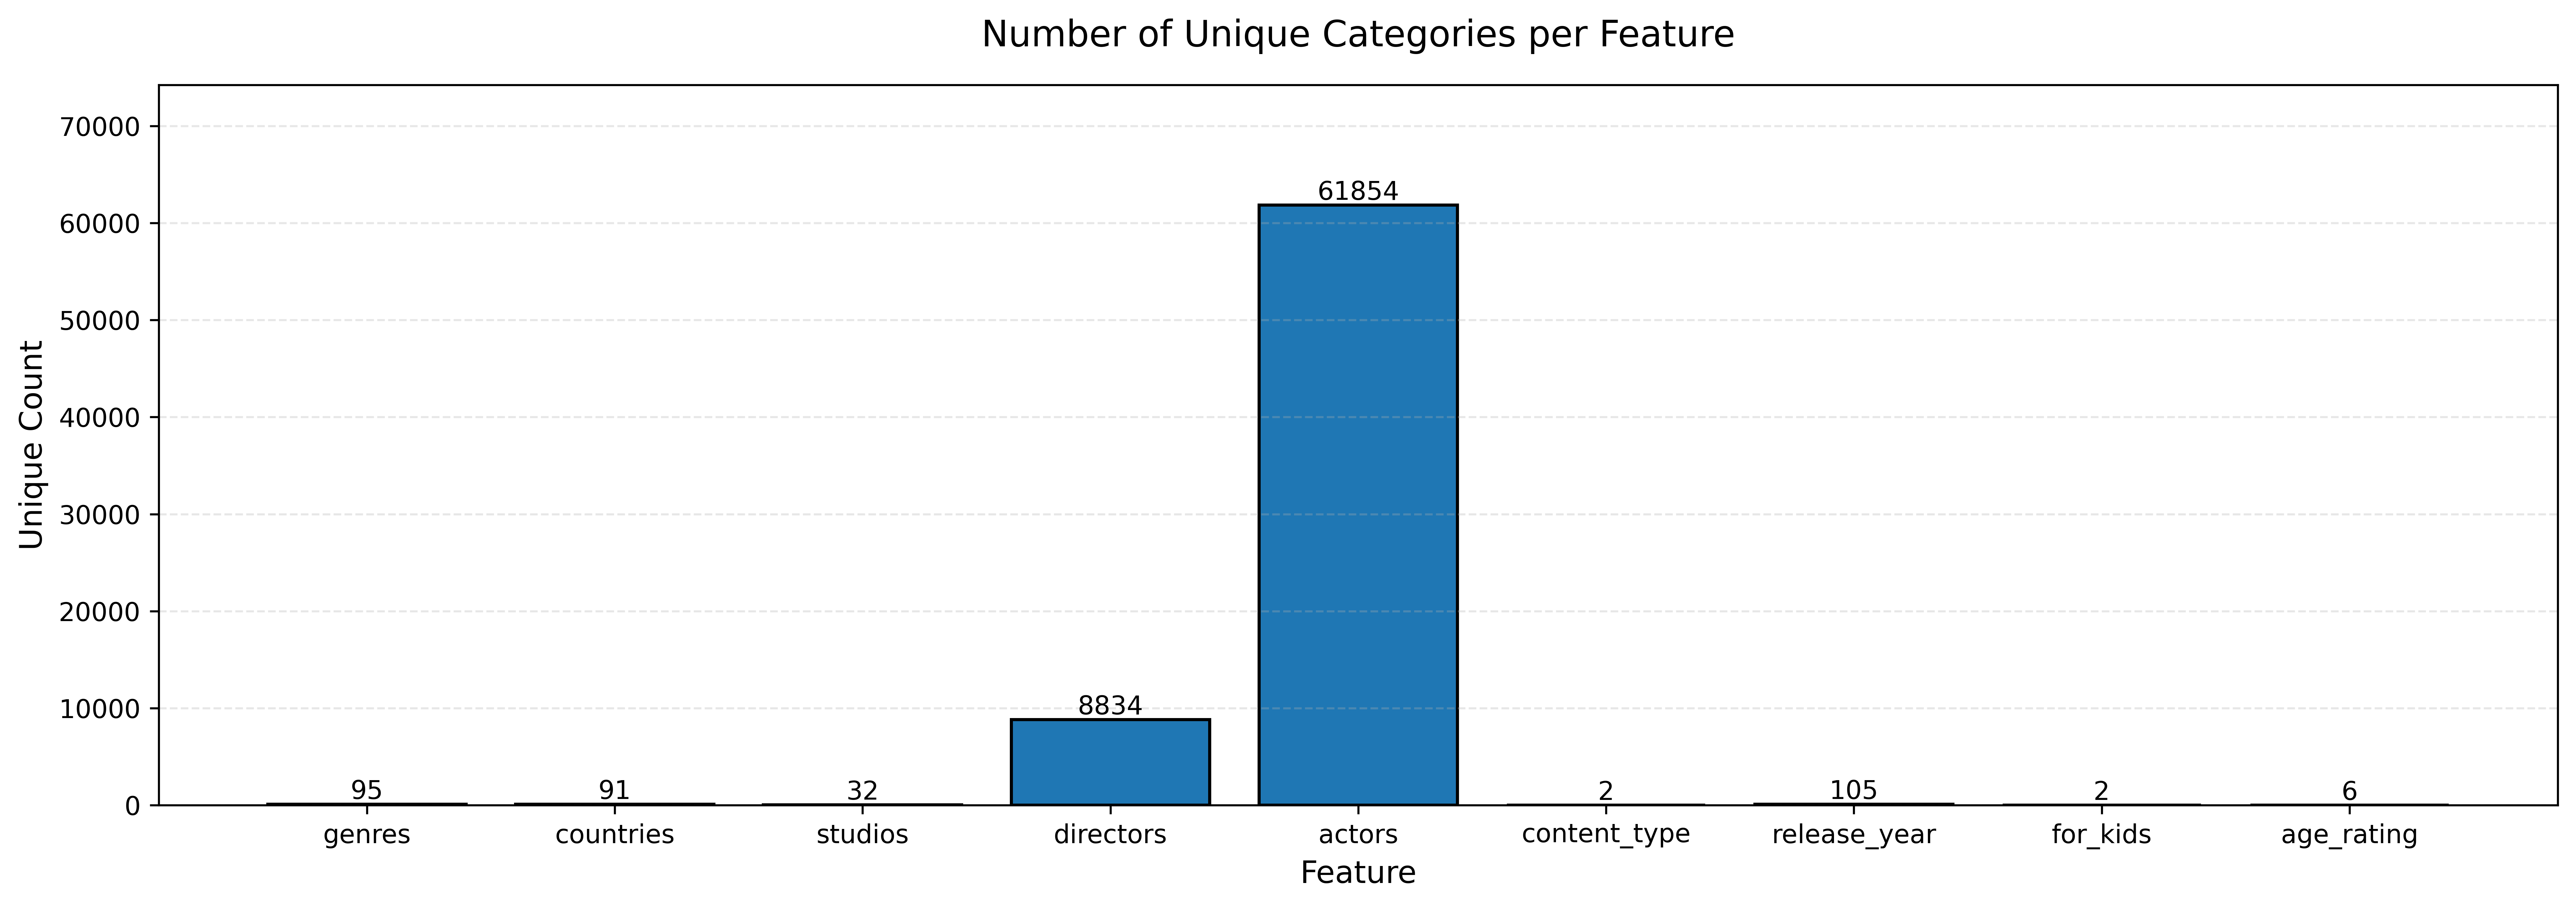

In [22]:
features = ['content_type', 'release_year', 'for_kids', 'age_rating']
unique_counts.update({feat: items[feat].nunique() for feat in features})

labels = list(unique_counts.keys())
counts = list(unique_counts.values())

plt.figure(figsize=(14, 5))
plt.rcParams['figure.dpi'] = 600
bars = plt.bar(labels, counts, edgecolor='black', linewidth=1.2)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height + 0.1,
             f'{int(height)}',
             ha='center', va='bottom')

plt.title('Number of Unique Categories per Feature', fontsize=14, pad=15)
plt.ylabel('Unique Count', fontsize=12)
plt.xlabel('Feature', fontsize=12)
plt.ylim(0, max(counts) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
def most_common_cat(df, col, n=None, th=None):

  values = []

  for l in df.dropna(subset=[col])[col].apply(lambda x: [i.strip() for i in x.split(',')]):
    values += l

  if n:
    return Counter(values).most_common(n)

  elif th:
    value_counts = Counter(values)
    total = sum(value_counts.values())

    filtered = {
        value: count
        for value, count in value_counts.items()
        if (count / total) >= th
        }
    return filtered
  else:
    return Counter(values)

In [24]:
most_common_cat(items, 'genres', n=15)

[('драмы', 5431),
 ('комедии', 3858),
 ('зарубежные', 3503),
 ('мелодрамы', 2778),
 ('триллеры', 2418),
 ('русские', 2216),
 ('приключения', 1877),
 ('боевики', 1820),
 ('документальное', 1339),
 ('криминал', 1306),
 ('детективы', 1224),
 ('фантастика', 1118),
 ('семейное', 1089),
 ('ужасы', 1033),
 ('фэнтези', 999)]

In [25]:
most_common_cat(items, 'countries', n=15)

[('США', 5065),
 ('Россия', 4340),
 ('Франция', 1521),
 ('СССР', 1417),
 ('Великобритания', 1272),
 ('Канада', 512),
 ('Германия', 446),
 ('Украина', 372),
 ('Италия', 332),
 ('Испания', 295),
 ('Республика Корея', 247),
 ('Швеция', 210),
 ('Япония', 198),
 ('Австралия', 189),
 ('Бельгия', 182)]

In [26]:
most_common_cat(items, 'studios', n=5)

[('HBO', 355),
 ('Ленфильм', 258),
 ('Sony Pictures', 164),
 ('рентв', 52),
 ('Paramount', 46)]

In [27]:
most_common_cat(items, 'actors', n=10)

[('Николас Кейдж', 59),
 ('Сергей Никоненко', 58),
 ('Армен Джигарханян', 55),
 ('Лев Дуров', 54),
 ('Брюс Уиллис', 53),
 ('Сэмюэл Л. Джексон', 51),
 ('Роберт Де Ниро', 51),
 ('Раиса Рязанова', 50),
 ('Андрей Мерзликин', 50),
 ('Тимофей Трибунцев', 49)]

In [28]:
most_common_cat(items, 'directors', n=10)

[('Оливье Шиабоду', 511),
 ('Денис Марти', 58),
 ('Денис Франческо', 49),
 ('Антонио Адамо', 44),
 ('Кови', 40),
 ('Глова Роман Юрьевич', 36),
 ('Роман', 34),
 ('Газзман', 32),
 ('Сергей Зарев', 30),
 ('Франческо Фанелли', 30)]

When working with our categorical item features, we will take special care to reduce their cardinality.

In [29]:
# Take a look at the descriptions

for d in items['description'][:5]:
  print(d)
  print()
  print('-'*50)
  print()

Мелодрама легендарного Педро Альмодовара «Поговори с ней» в 2003 году получила премию «Оскар» за лучший сценарий.  Журналист Марко берет интервью у знаменитой женщины-тореро Лидии и вскоре влюбляется в нее. Однако он не успевает признаться ей в любви – их разлучает страшная трагедия: бык на корриде бросается на несчастную Лидию, и та впадает в кому. Марко дни и ночи проводит у ее постели в больнице, но никаких улучшений не предвидится. Вскоре Марко знакомится в больнице с Бениньо, человеком, который уже не первый год ухаживает за своей возлюбленной Алисией, которая тоже лежит в коме. Объединенные общим горе мужчины сближаются, и однажды Бениньо дает страдающему Марко простой совет: «Поговори с ней». С тех пор Марко ведет с бесчувственной Лидией долгие разговоры, которые одни только и могут изменить ситуацию к лучшему и спасти влюбленных. Для того чтобы узнать, как дальше будут развиваться события, рекомендуем смотреть онлайн «Поговори с ней».

------------------------------------------

In [30]:
# Take a look at the keywords

for d in items['keywords'][:5]:
  print(d)
  print()
  print('-'*50)
  print()

Поговори, ней, 2002, Испания, друзья, любовь, сильные, женщины, преодоление, трудностей, отношения, дружба, отношения, паре, отношения, мужчины, женщины, романтические, отношения, потеря, близких, флешбек, видения, несчастный, случай, разговоры, любовники, кома

--------------------------------------------------

Голые, перцы, 2014, США, друзья, свадьбы, преодоление, трудностей, расставания, отношения, дружба, риск, недоразумение, мужская, дружба, мальчишники, девичники

--------------------------------------------------

Тактическая, сила, 2011, Канада, бандиты, гангстеры, преступления, преодоление, трудностей, убийства, убийцы, настоящие, мужчины, риск, недоразумение, силы, правопорядка, борьба, за, выживание, спецназ, коллектив, команда, перестрелки, враги, или, вражда

--------------------------------------------------

45, лет, 2015, Великобритания, брак, жизнь, любовь, психология, семейные, проблемы, семья, отношения, конфликты, отношениях, отношения, паре, отношения, мужчины, же

At first glance, it seems that the keywords feature is a better candidate for feature engineering. After cleaning (removing numbers, proper nouns and stopwords), it will retain the most important words that capture information about the movie's plot, themes, etc. On the other hand, the description feature contains noise, such as names of actors, directors and other movies, which might dilute the signal. But perhaps a pre-trained Russian or multilingual transformer model could do the trick?

In [31]:
desc_len = items.dropna(subset=['description'])['description'].apply(lambda x: len(x.split()))

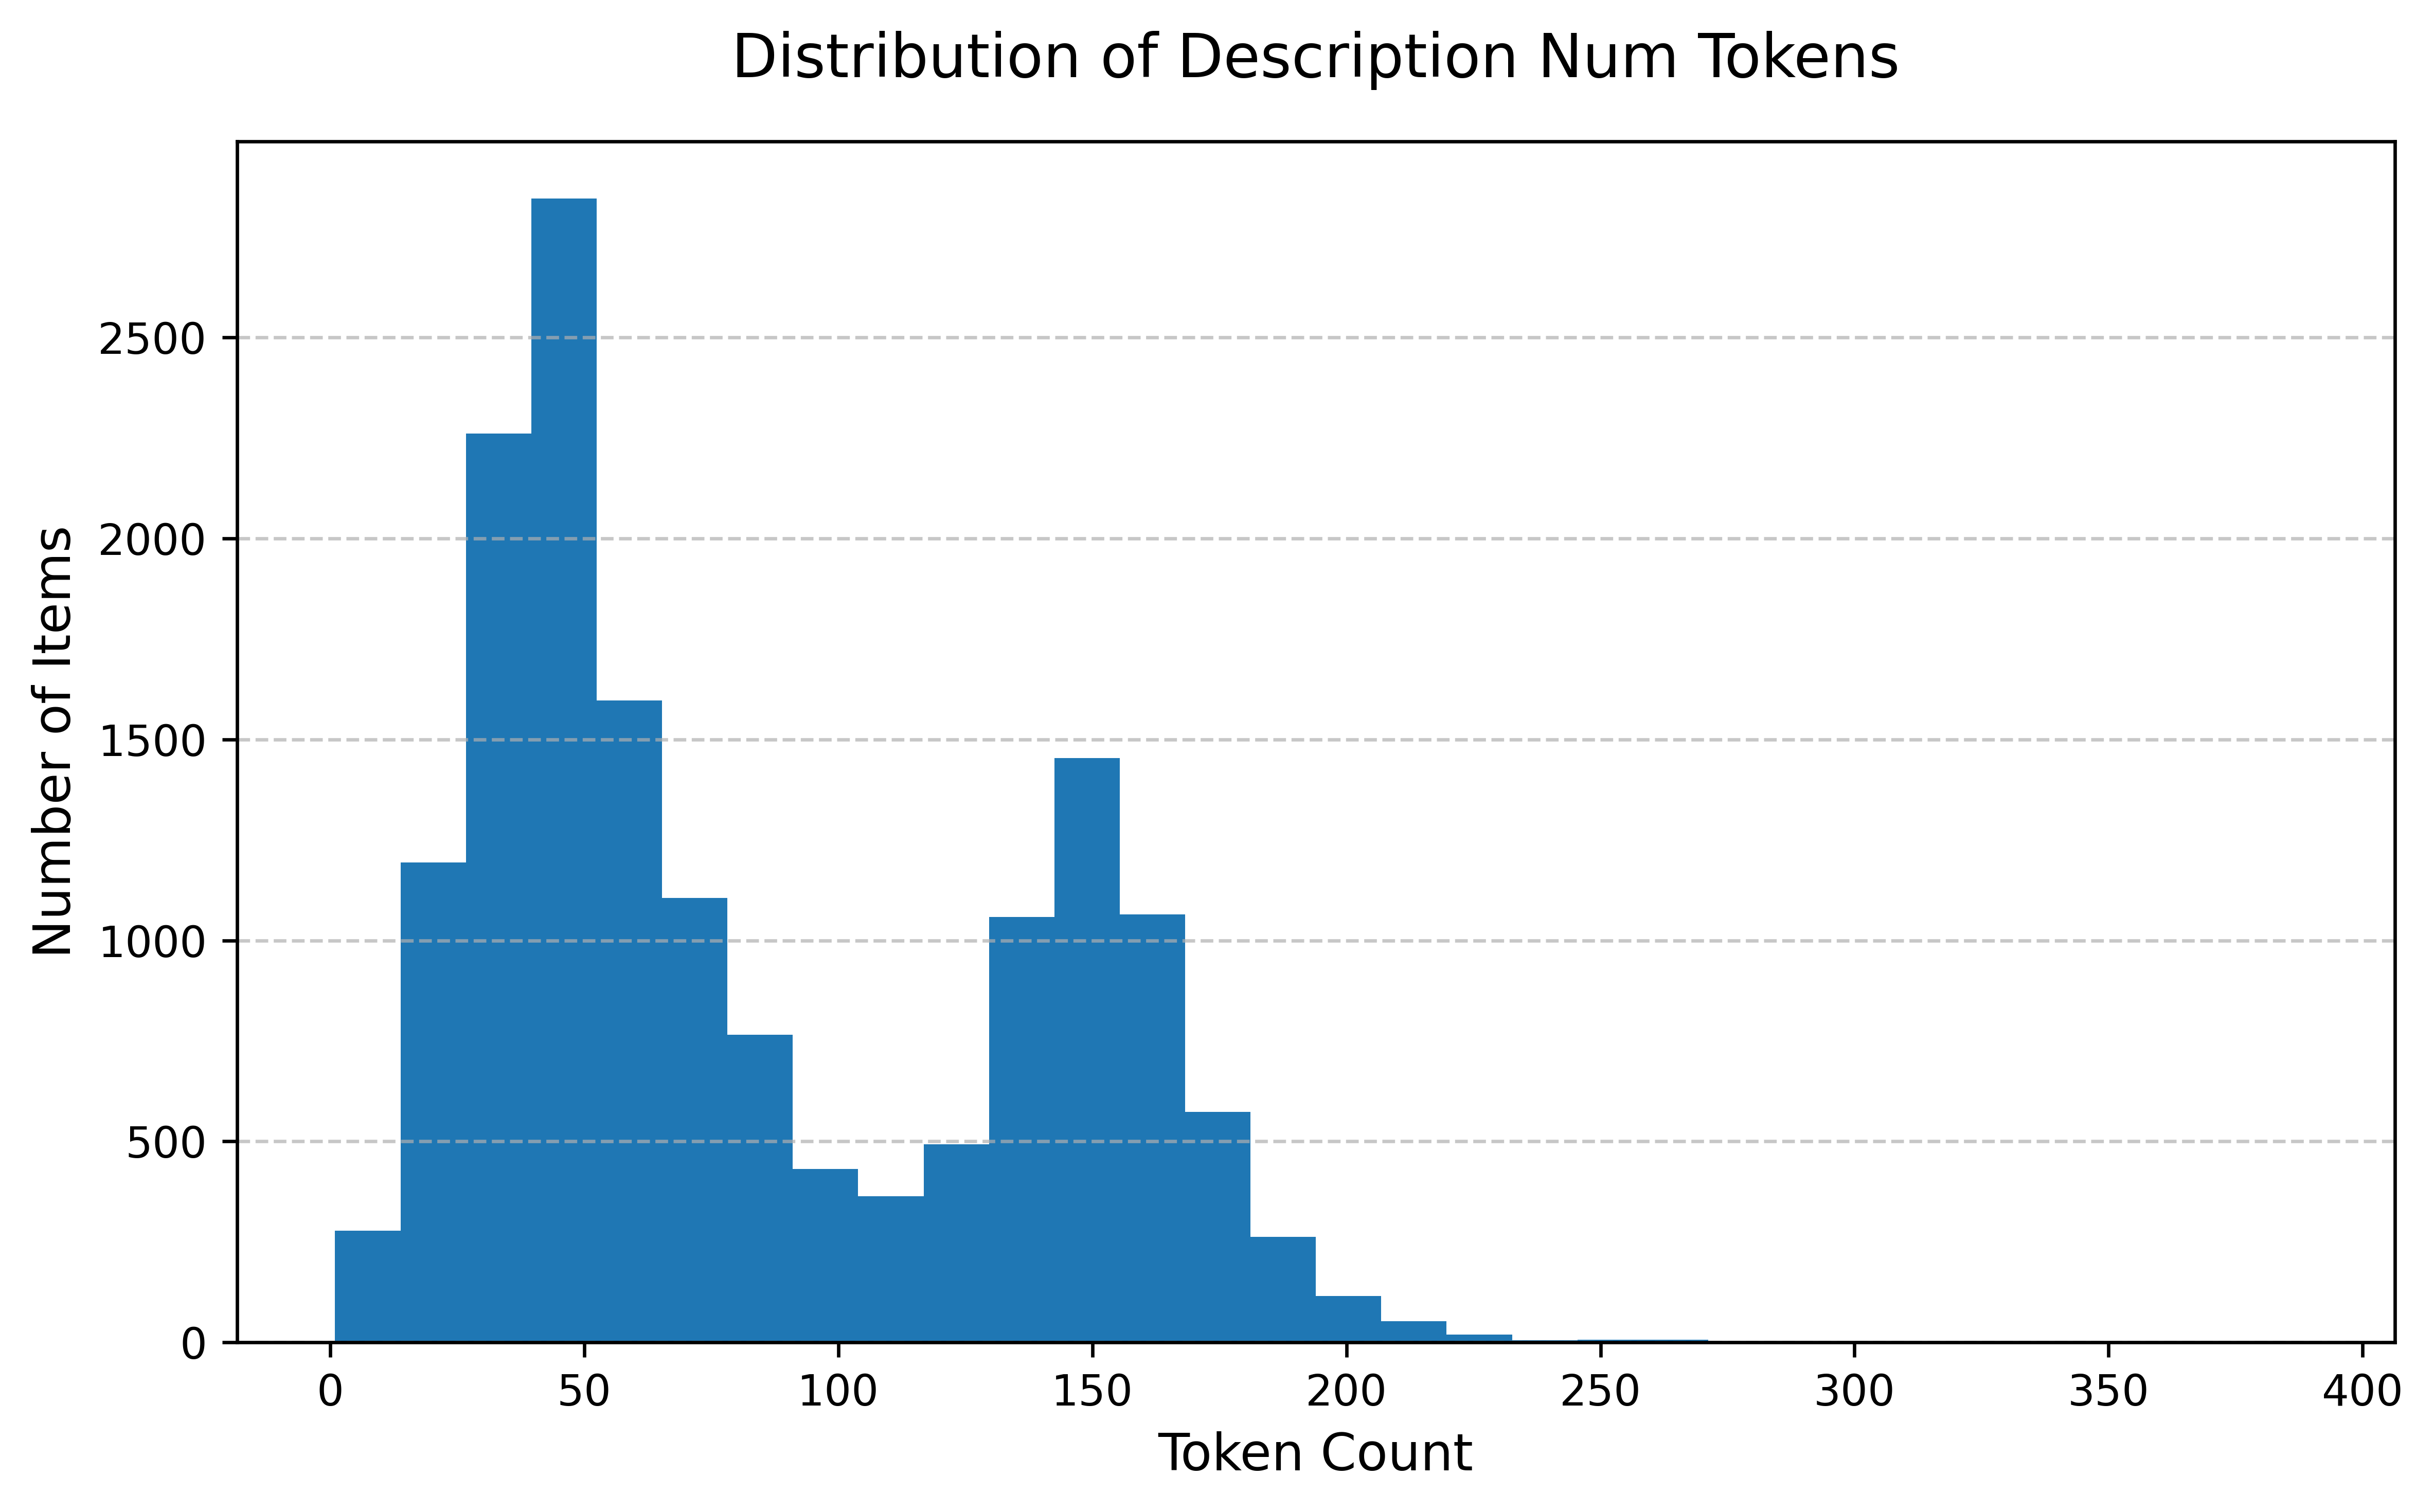

In [32]:
plt.figure(figsize=(8, 5))
plt.hist(desc_len, bins=30)
plt.title('Distribution of Description Num Tokens', fontsize=14, pad=15)
plt.xlabel('Token Count', fontsize=12)
plt.ylabel('Number of Items', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Potentially useful item features include:

- content_type flag
- for_kids flag
- age_rating
- release_year converted into periods
- top genres
- top countries
- top studios
- top actors
- top directors
- movie title	and description encoded using a transformer model
- movie keywords encoded using text preprocessing and tf-idf

# Filtering and splitting

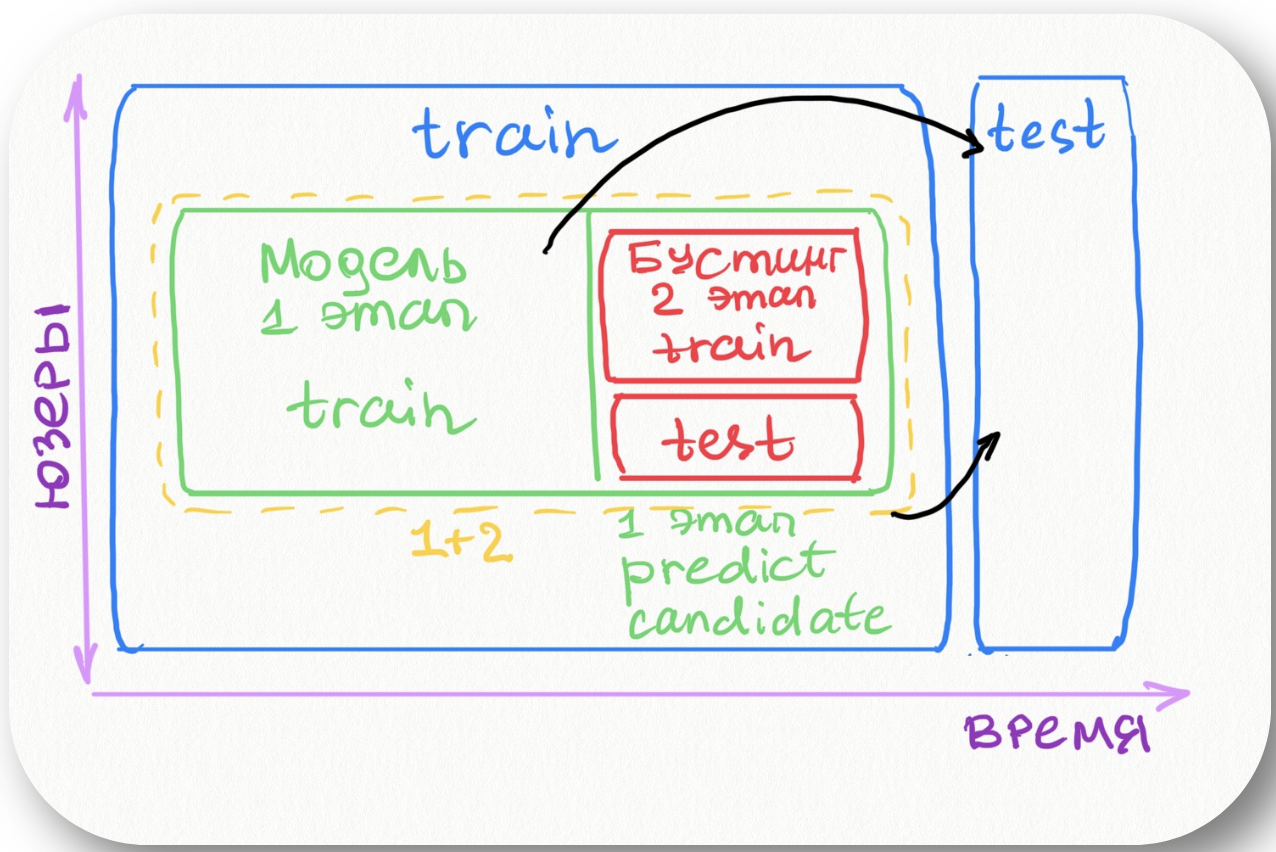

Global train-test split

The train set will be additionally split to train 1st and 2nd level models separately.

Final quality will be estimated using the 7-day `test` set:
- apply 1st level models to get predictions for the test set
- then apply 2nd level model to predict on the same set

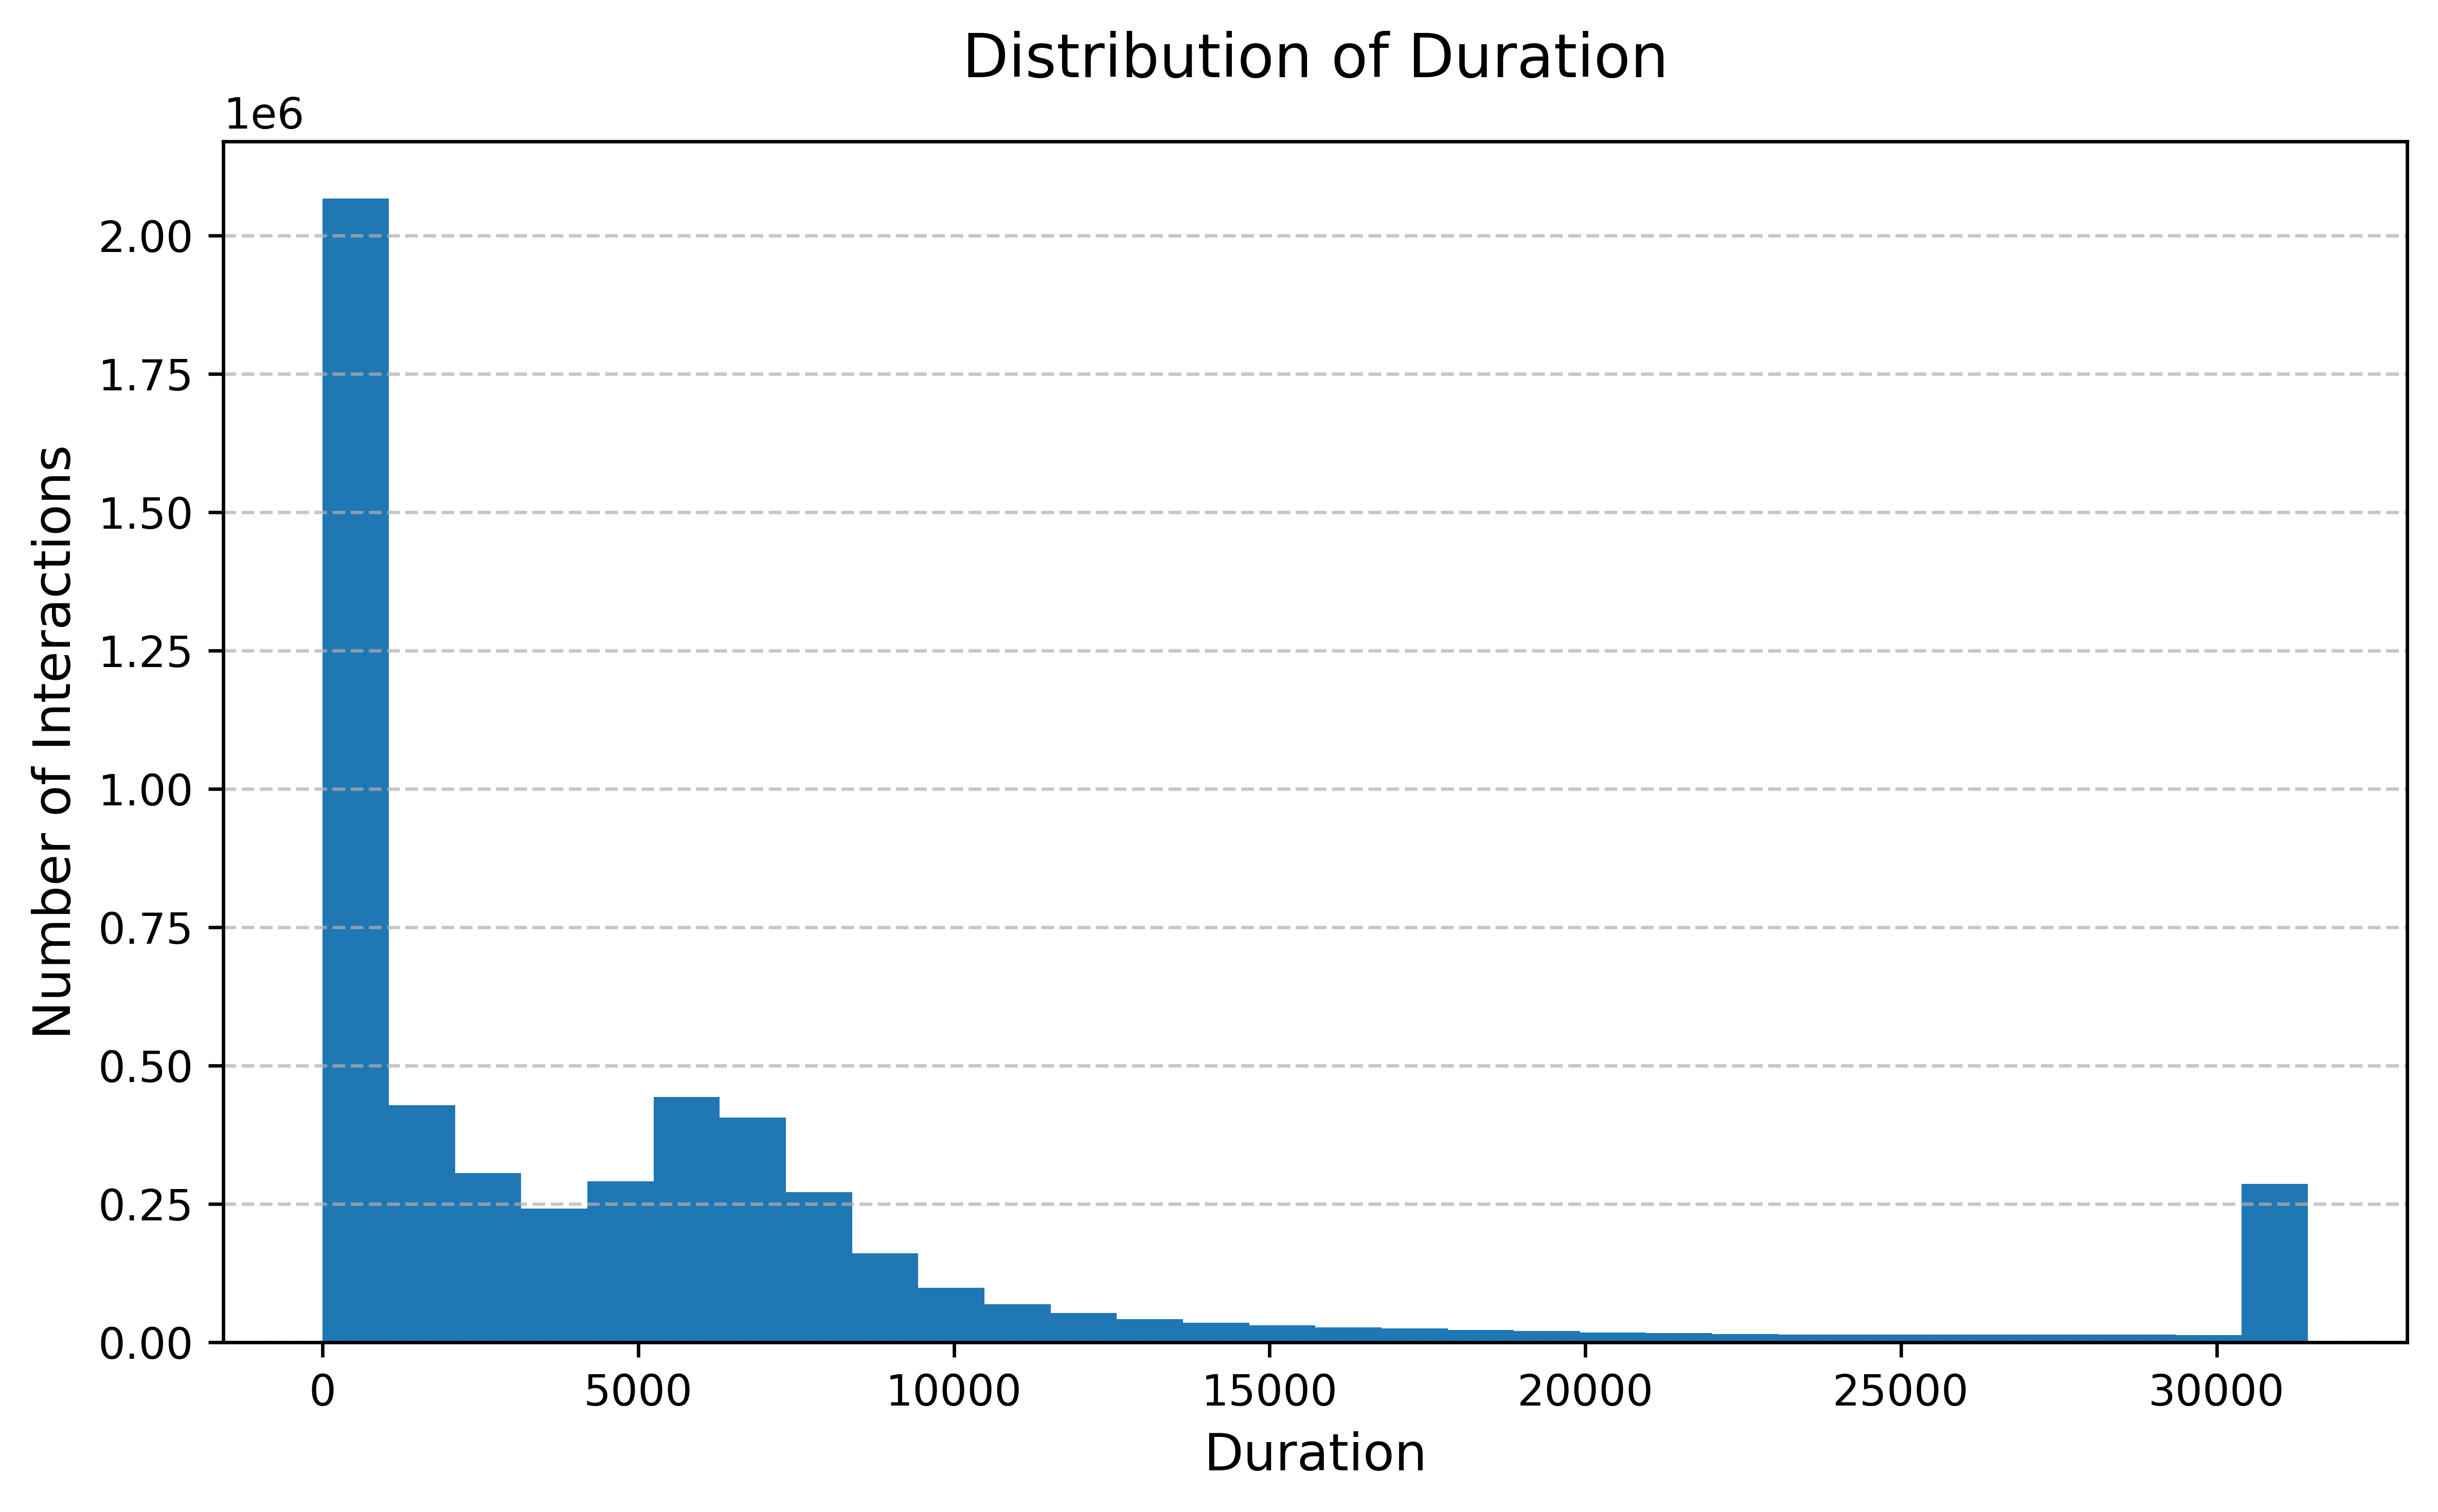

In [33]:
total_dur = interactions['total_dur']
upper_bound = total_dur.quantile(0.95)

plt.figure(figsize=(8, 5))
plt.hist(total_dur.clip(upper=upper_bound), bins=30)
plt.title('Distribution of Duration', fontsize=14, pad=15)
plt.xlabel('Duration', fontsize=12)
plt.ylabel('Number of Interactions', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

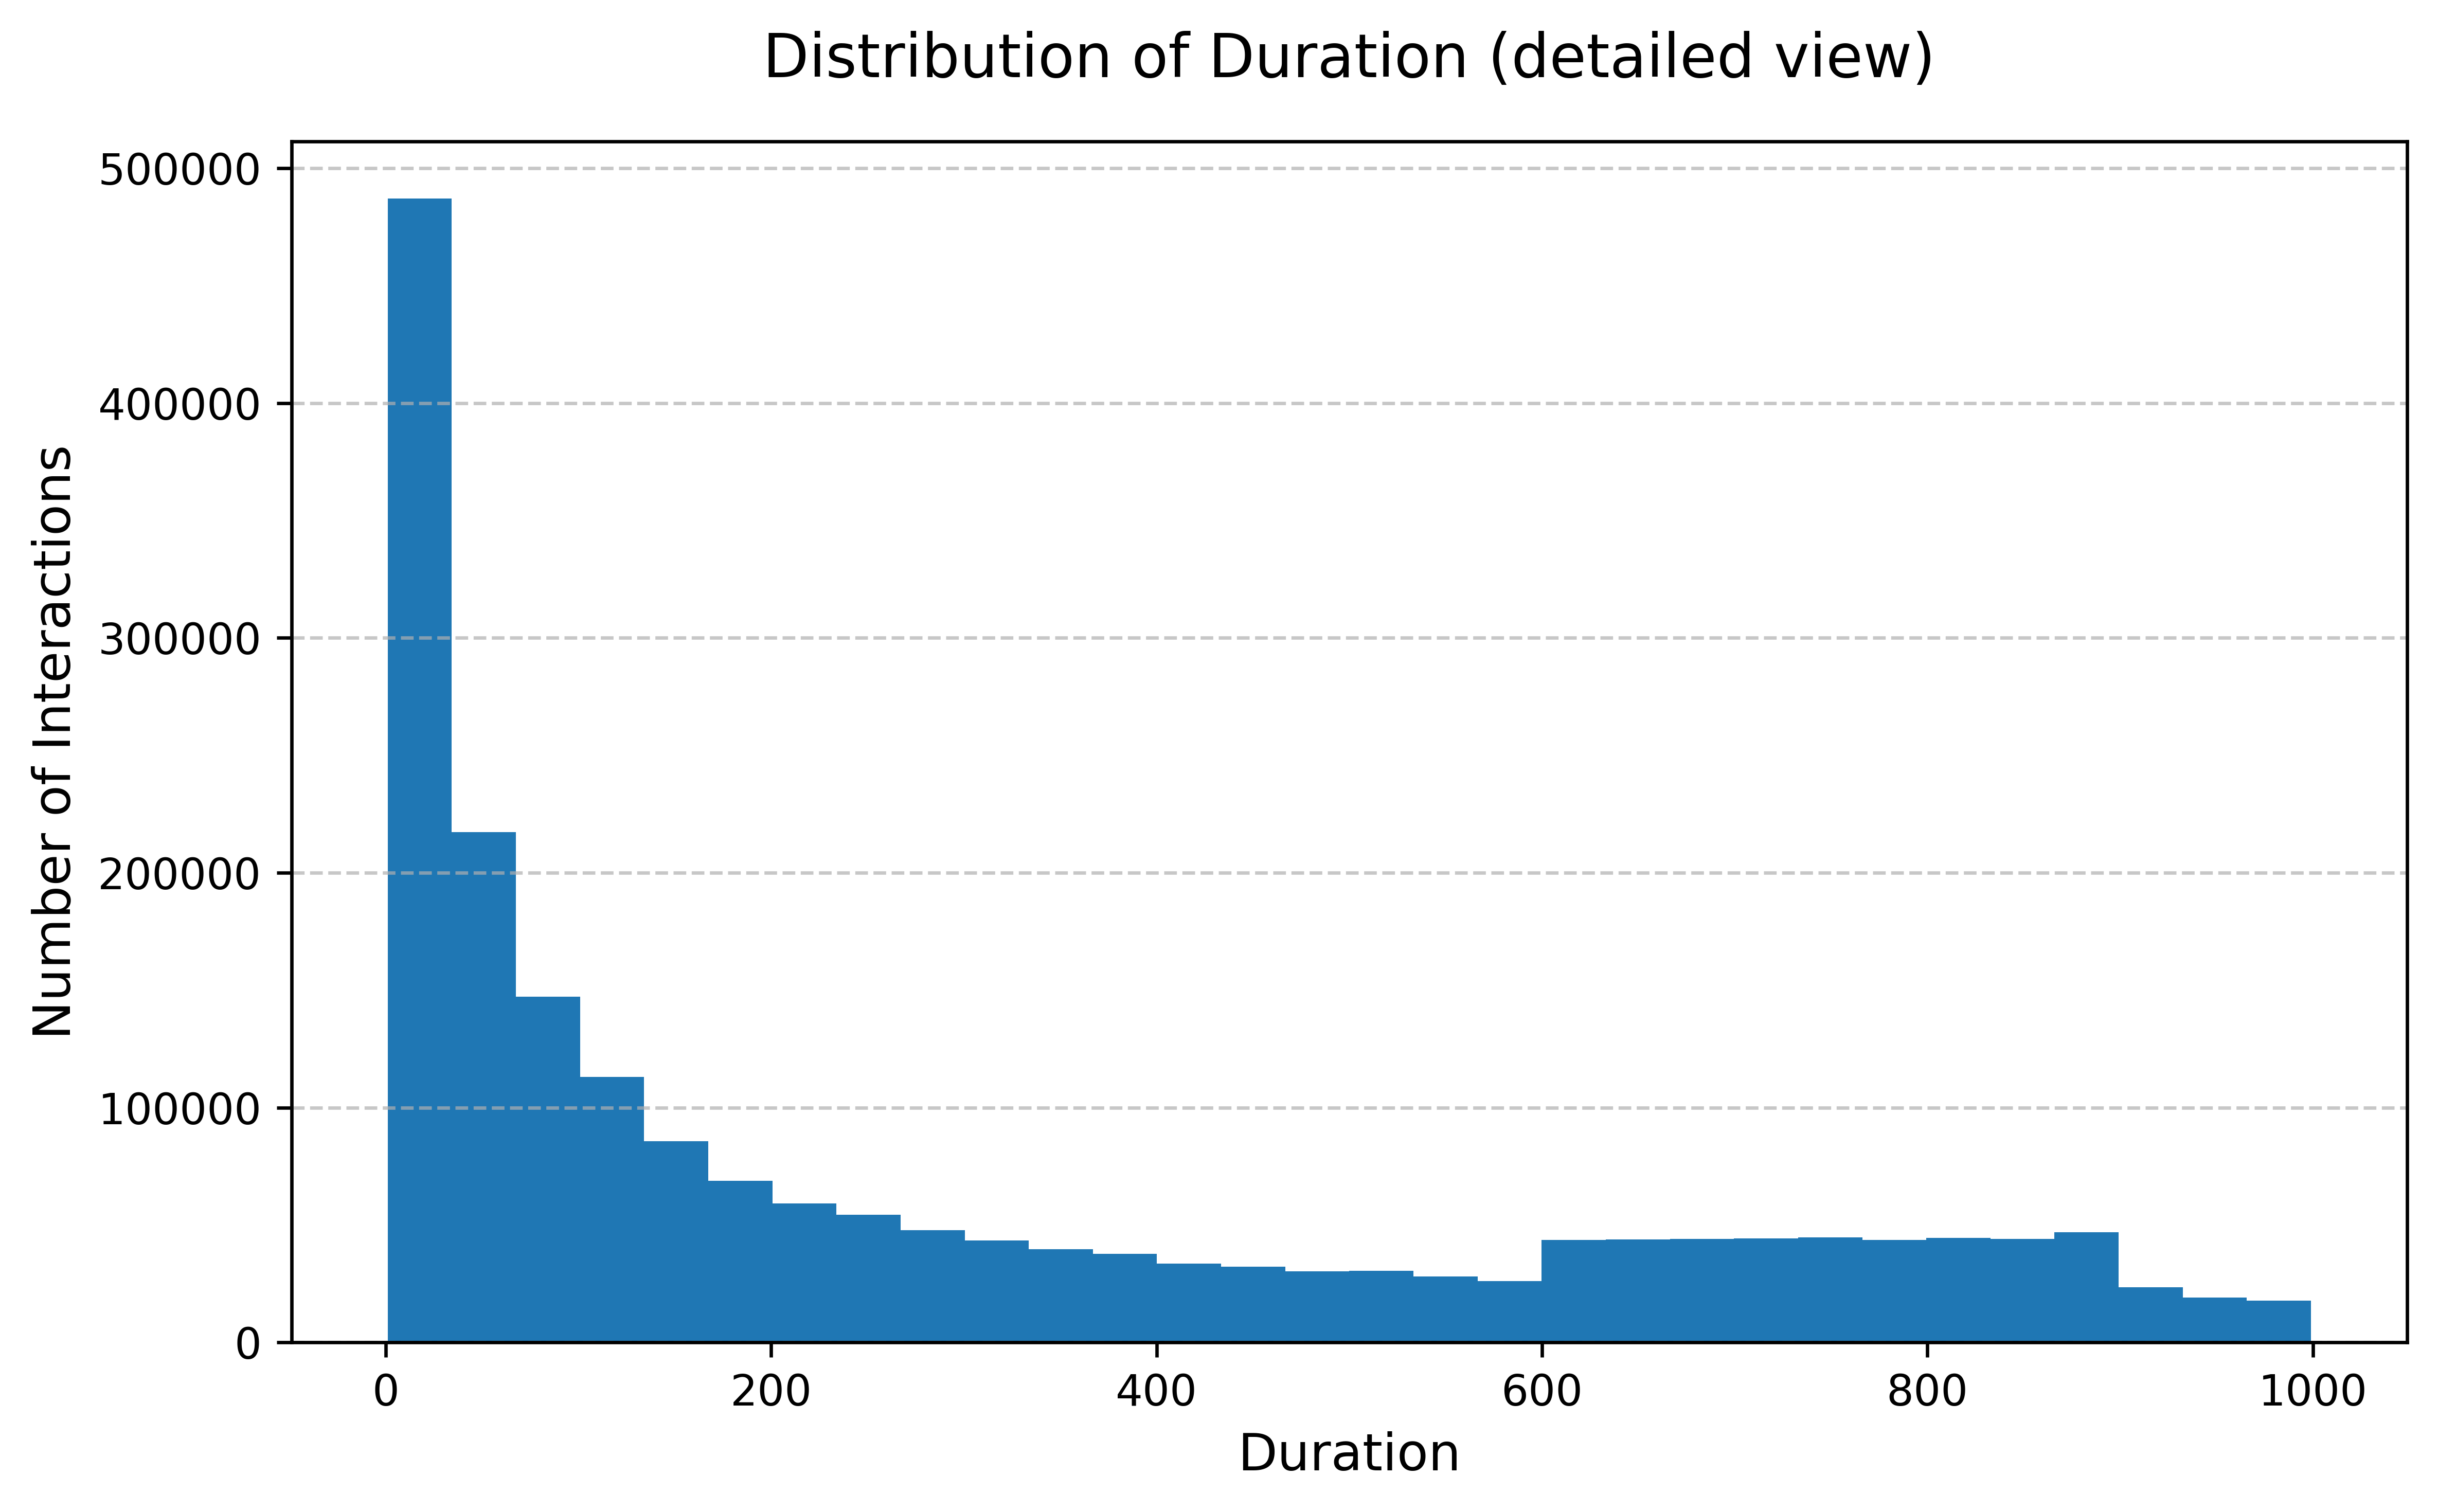

In [34]:
plt.figure(figsize=(8, 5))
plt.hist(total_dur[total_dur<1000], bins=30)
plt.title('Distribution of Duration (detailed view)', fontsize=14, pad=15)
plt.xlabel('Duration', fontsize=12)
plt.ylabel('Number of Interactions', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [35]:
# filter out random views
interactions = interactions[interactions['total_dur'] >= 300]

In [36]:
user_interactions_count = interactions.groupby('user_id')[['item_id']].count().reset_index()

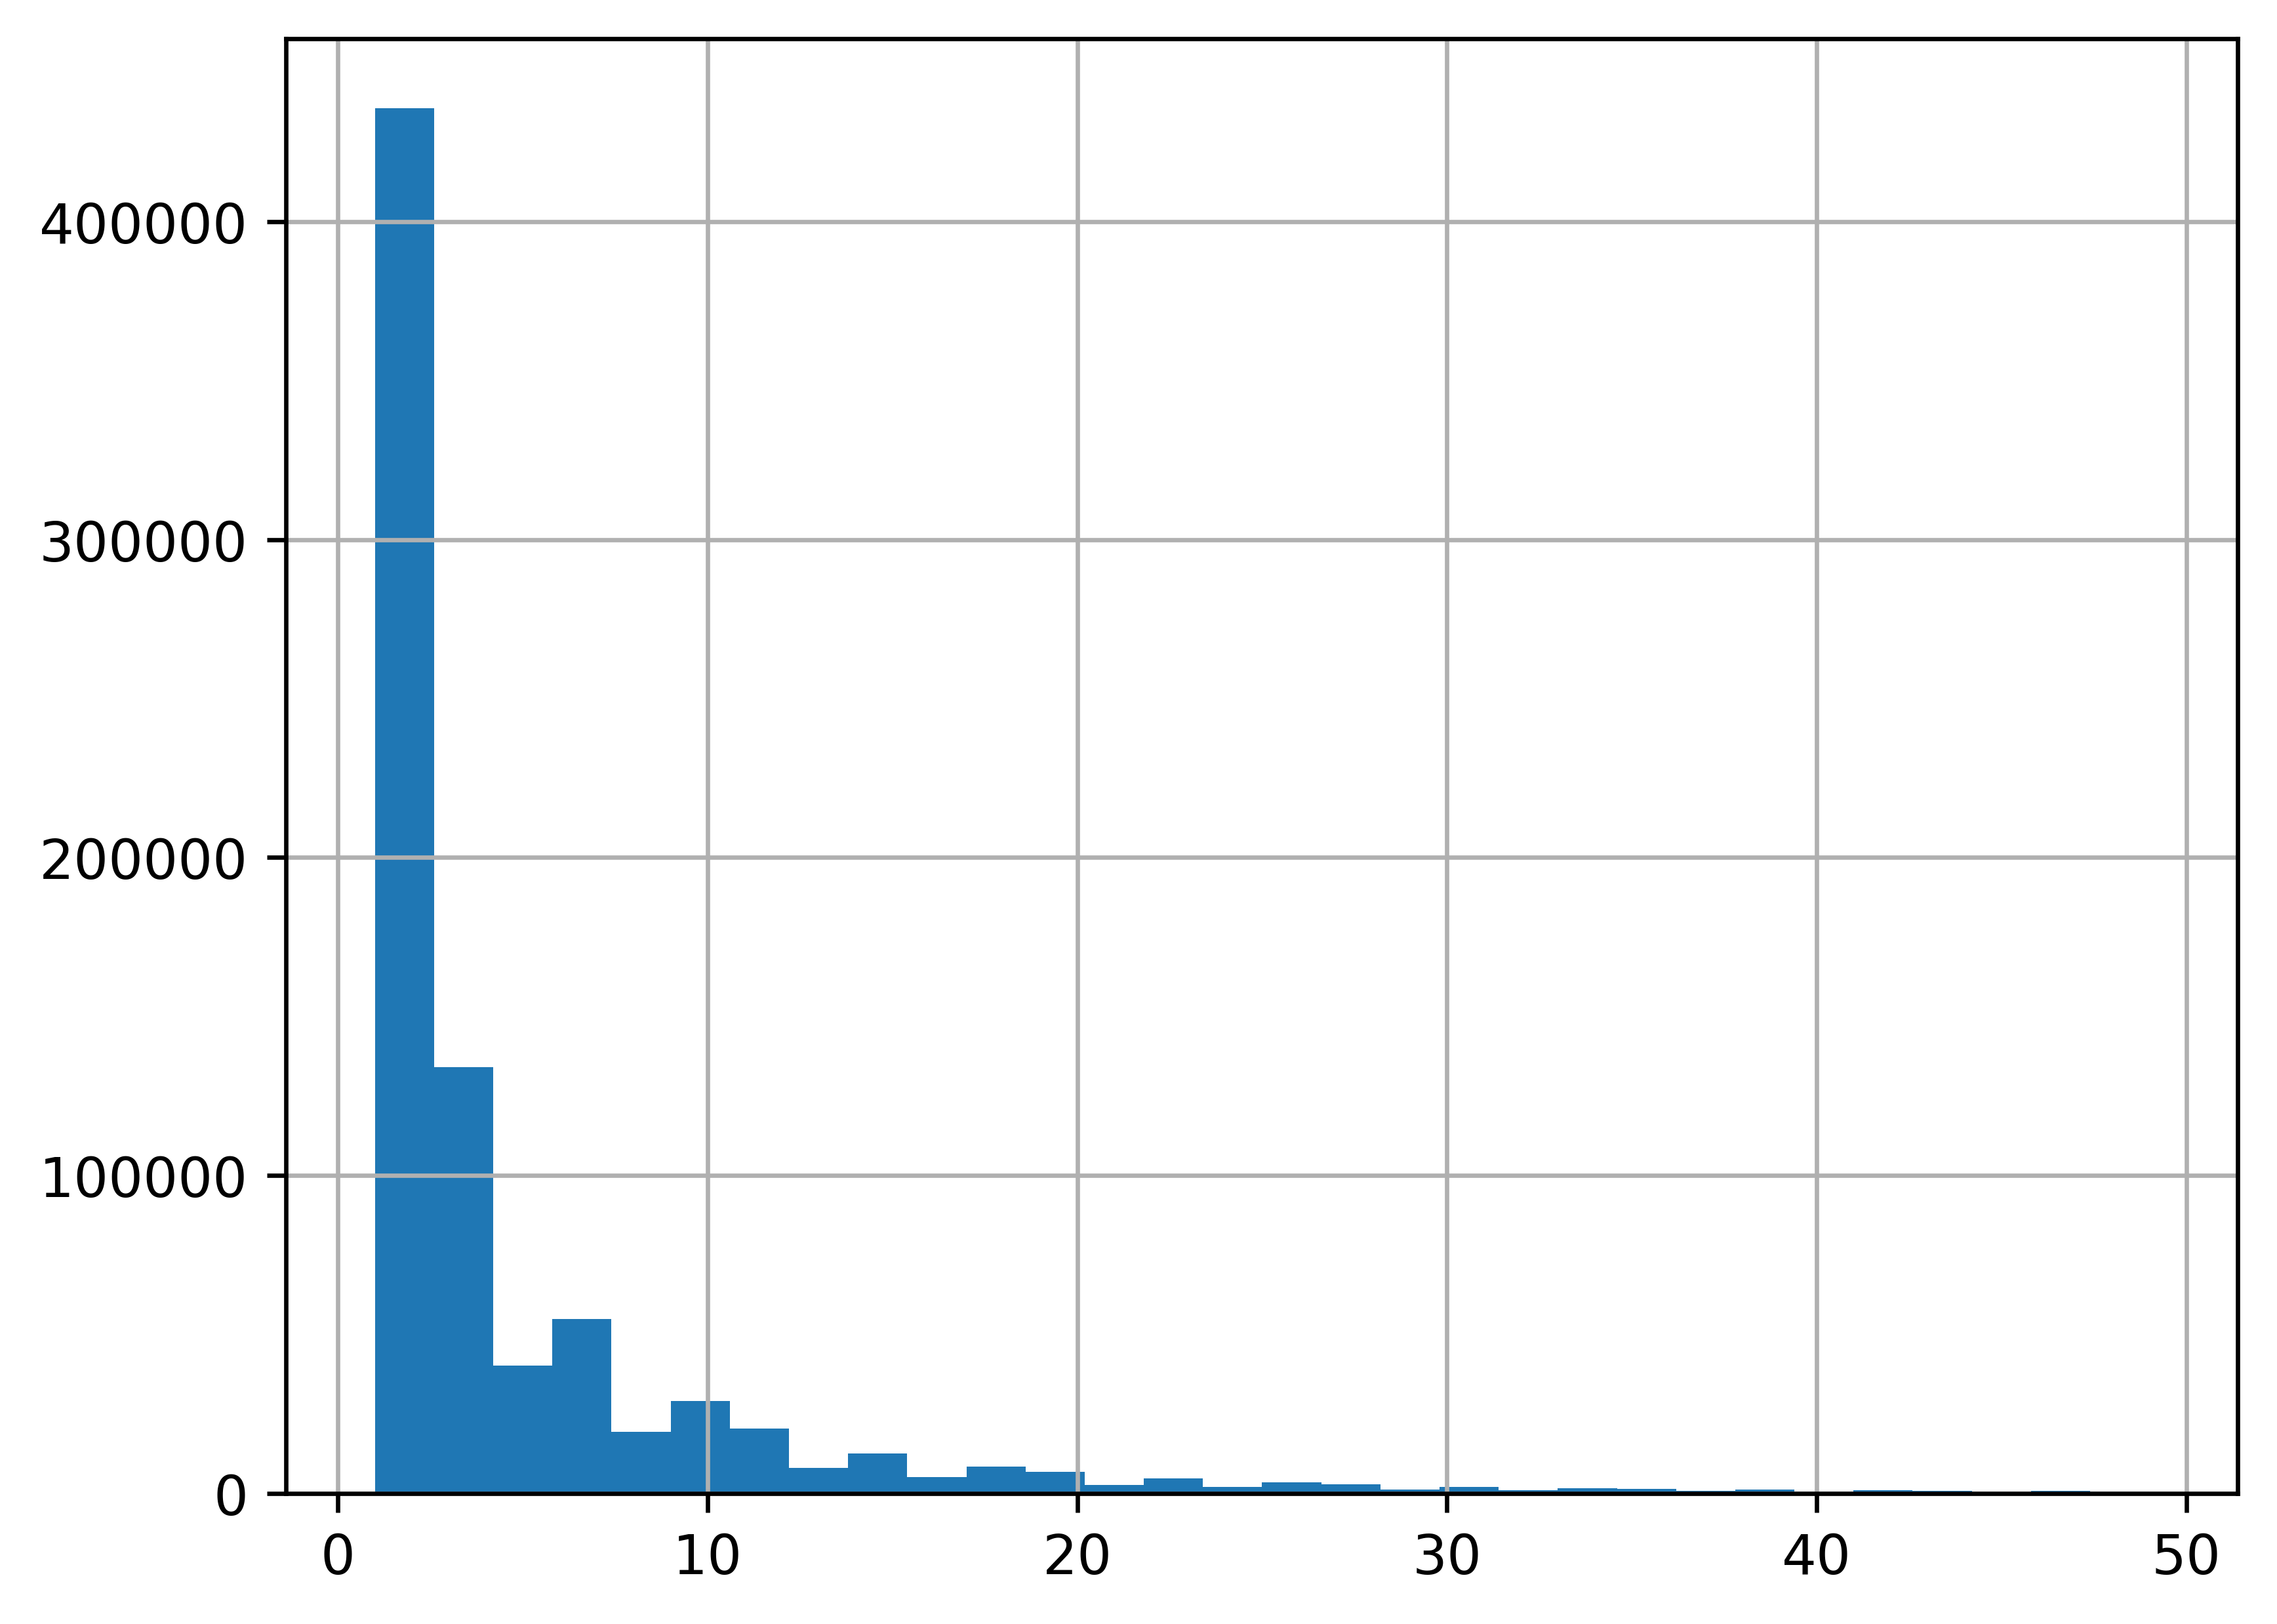

In [37]:
user_interactions_count[user_interactions_count['item_id'] < 50]['item_id'].hist(bins=30)
plt.show()

In [38]:
round(sum(user_interactions_count['item_id'] < 10) / user_interactions_count.shape[0], 2)

0.87

In [39]:
# filter out users with few interactions
filtered_users = user_interactions_count[user_interactions_count['item_id'] >= 10][['user_id']]
interactions = filtered_users.merge(interactions, how='left')

In [40]:
item_interactions_count = interactions.groupby('item_id')[['user_id']].count().reset_index()

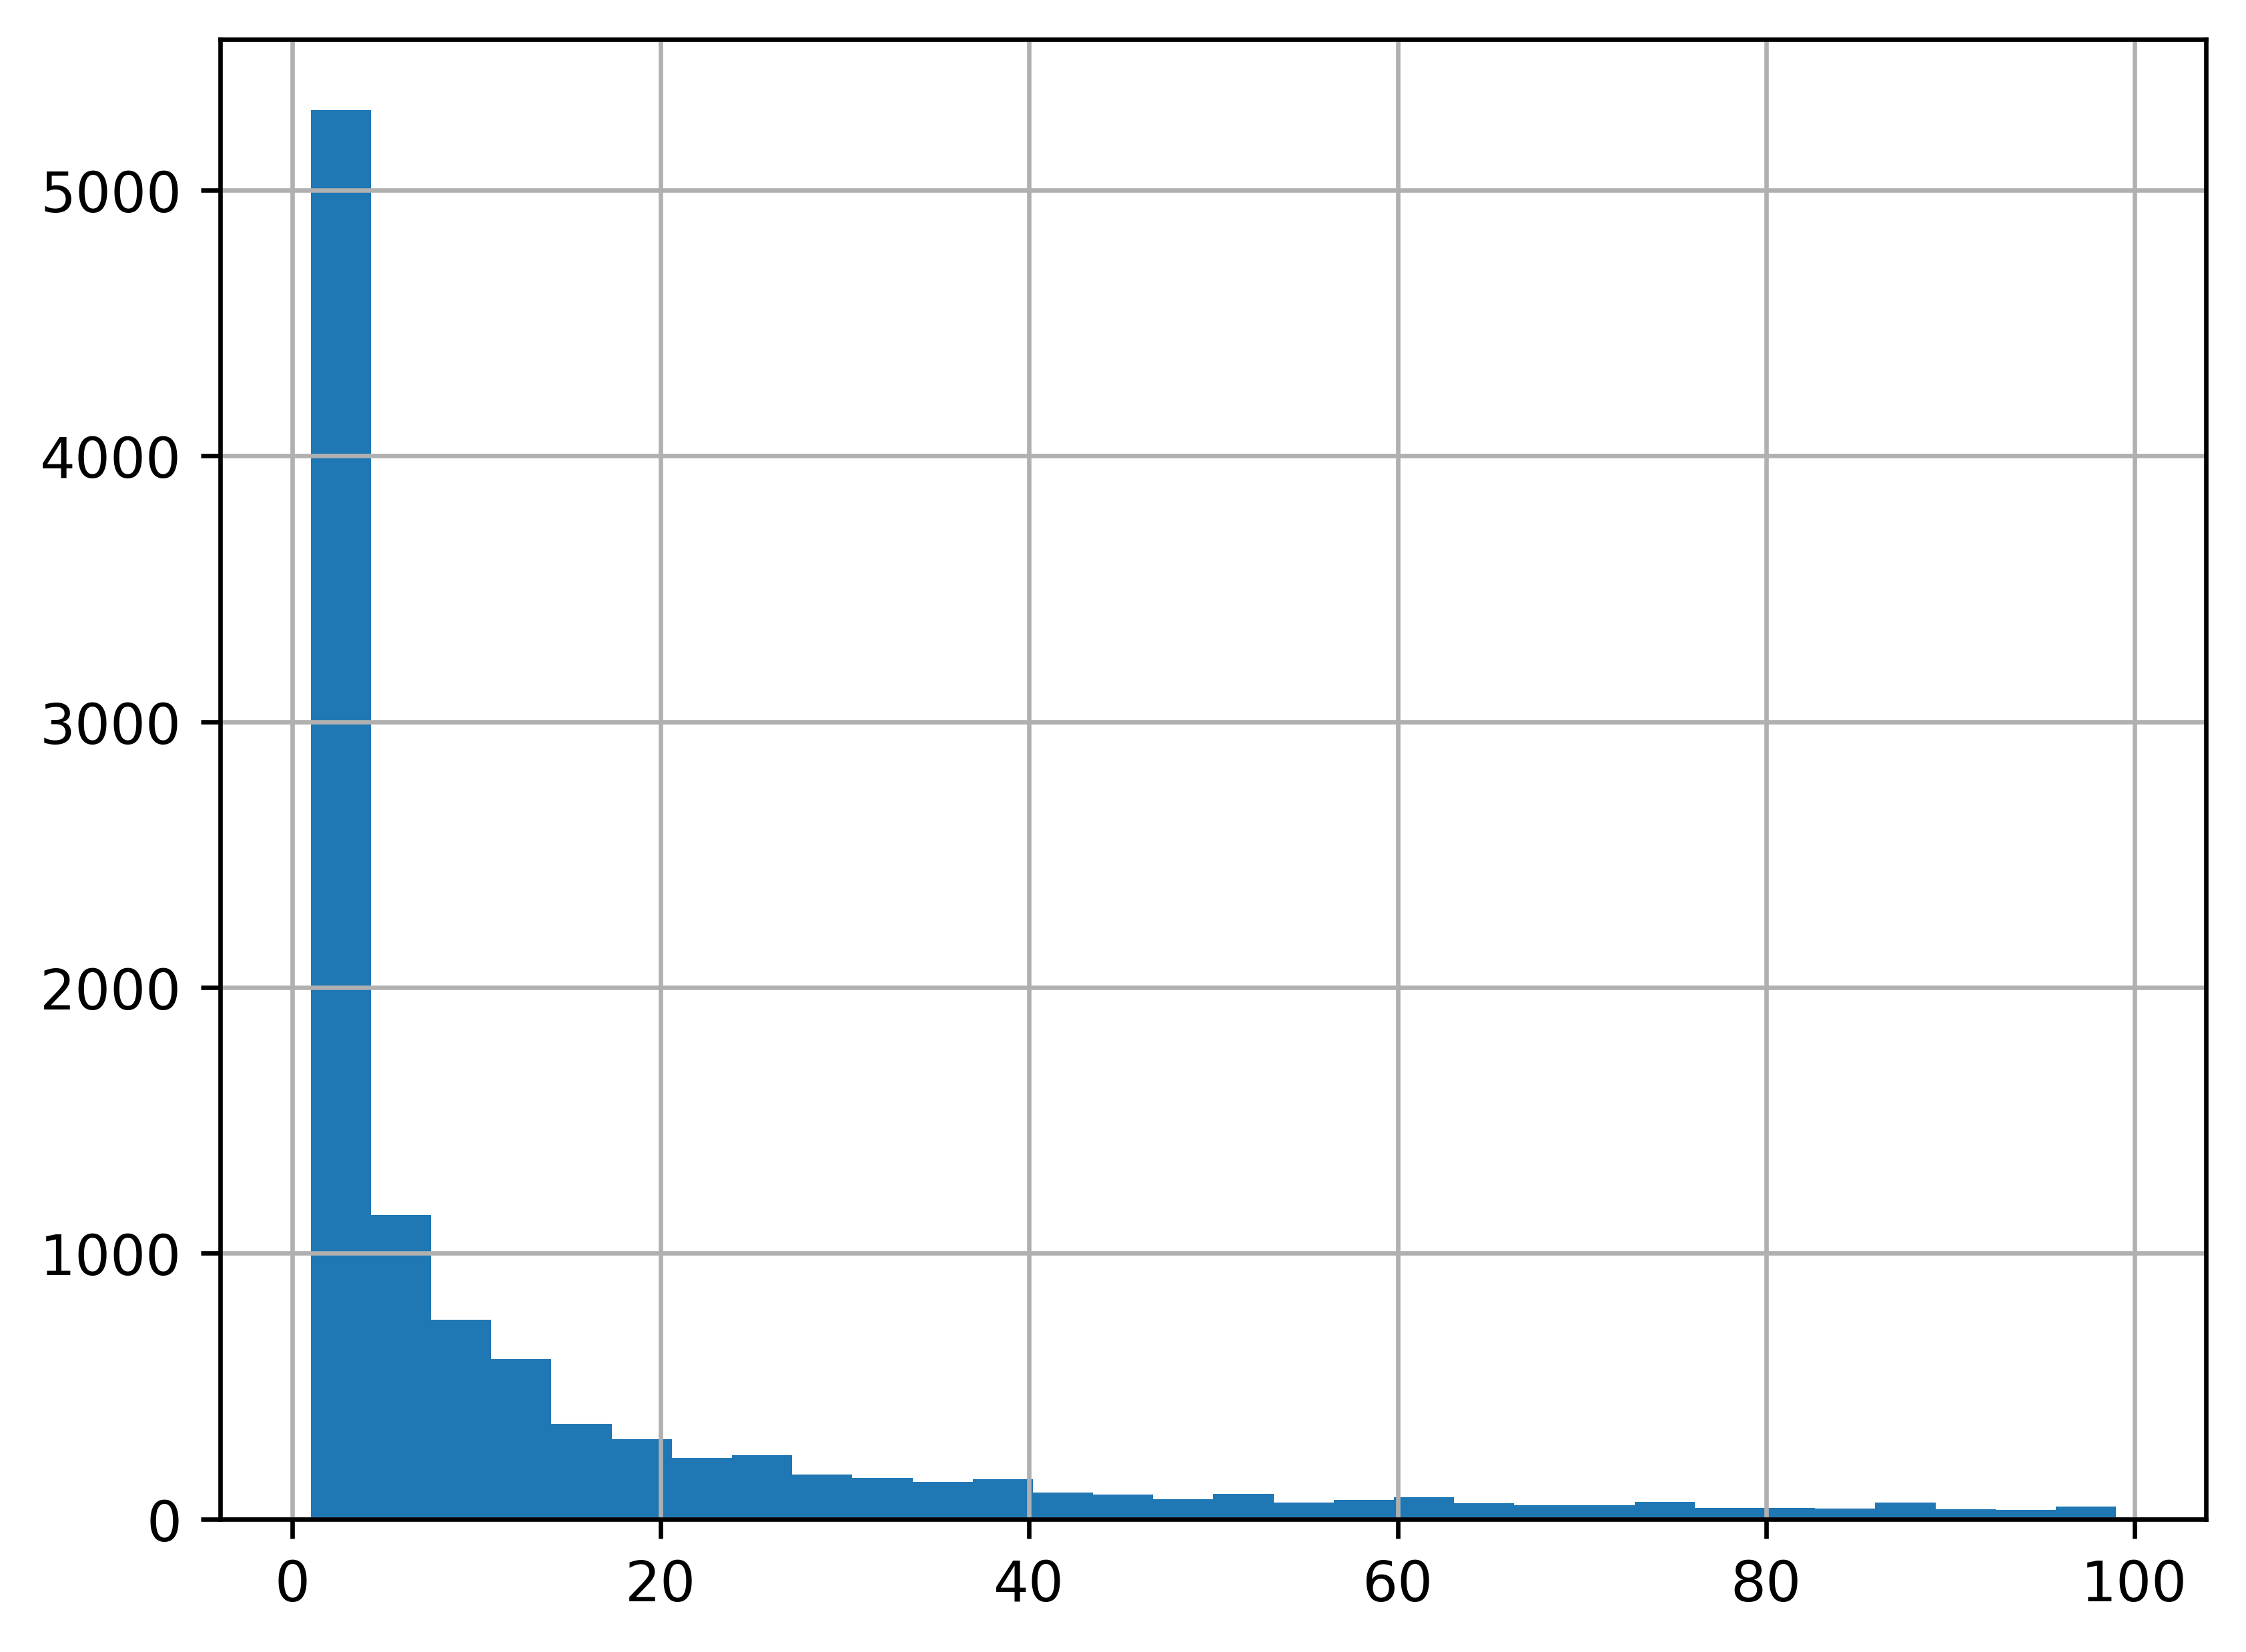

In [41]:
item_interactions_count[item_interactions_count['user_id'] < 100]['user_id'].hist(bins=30)
plt.show()

In [42]:
round(sum(item_interactions_count['user_id'] < 10) / item_interactions_count.shape[0], 2)

0.52

In [43]:
# filter out items with few interactions
filtered_items = item_interactions_count[item_interactions_count['user_id'] >= 10][['item_id']]
interactions = filtered_items.merge(interactions, how='left')

In [44]:
interactions.shape

(2300516, 5)

In [45]:
test_threshold = max_date - pd.Timedelta(days=7)
val_threshold = test_threshold - pd.Timedelta(days=60) # two months of data to train a 2nd level model

test = interactions[(interactions['last_watch_dt'] >= test_threshold)]
train_val = interactions[(interactions['last_watch_dt'] < test_threshold)]

val = train_val[(train_val['last_watch_dt'] >= val_threshold)]
train = train_val[(train_val['last_watch_dt'] < val_threshold)]

print(f"train: {train.shape}")
print(f"val: {val.shape}")
print(f"test: {test.shape}")

train: (881660, 5)
val: (1246263, 5)
test: (172593, 5)


# Helper functions for metrics calculation

In [46]:
def recall(df: pd.DataFrame, pred_col='preds', true_col='item_id', k=30) -> float:
    recall_values = []
    for _, row in df.iterrows():
      num_relevant = len(set(row[true_col]) & set(row[pred_col][:k]))
      num_true = len(row[true_col])
      recall_values.append(num_relevant / num_true)
    return round(np.mean(recall_values), 4)

In [47]:
def precision(df: pd.DataFrame, pred_col='preds', true_col='item_id', k=30) -> float:
    precision_values = []
    for _, row in df.iterrows():
      num_relevant = len(set(row[true_col]) & set(row[pred_col][:k]))
      num_true = min(k, len(row[true_col])) # the correct way would be to use k but here we will use this version
      precision_values.append(num_relevant / num_true)
    return round(np.mean(precision_values), 4)

In [48]:
def mrr(df: pd.DataFrame, pred_col='preds', true_col='item_id', k=30) -> float:
    mrr_values = []
    for _, row in df.iterrows():
      intersection = set(row[true_col]) & set(row[pred_col][:k])
      user_mrr = 0
      if len(intersection) > 0:
          for item in intersection:
              user_mrr = max(user_mrr, 1 / (row[pred_col].index(item) + 1))
      mrr_values.append(user_mrr)
    return round(np.mean(mrr_values), 4)

# Baseline

In this section we will create a basic two-stage model:

- no text features
- no complex preprocessing, most features will be fed into the model as is
- no hyperparameter tuning
- only one 1st level model

## Stage 1: train a single 1st level model

- train a bpr model on the train set

- predict for the validation set and calculate the metrics

We will exclude cold users from the validation set

In [49]:
val = val[val['user_id'].isin(train['user_id'].unique())]

In [50]:
val.reset_index(drop=True, inplace=True)

In [51]:
val.head()

item_id  user_id last_watch_dt  total_dur  watched_pct
0        0   184560    2021-07-18      13278         50.0
1        0   379871    2021-07-04       4279          3.0
2        0   427911    2021-08-11       5363         38.0
3        0   573405    2021-08-01      10164          9.0
4        0   968581    2021-08-04       7310          6.0

In [52]:
values = train.watched_pct.values
rows = train.user_id.values
cols = train.item_id.values

train_sparse = sparse.csr_matrix((values, (rows, cols)))

In [53]:
train_sparse.shape

(1097517, 16512)

In [54]:
matrix_size = train.user_id.nunique() * train.item_id.nunique() # Number of possible interactions in the matrix
num_interactions = len(train_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100 * (1 - (num_interactions / matrix_size))
sparsity

99.79592704093007

In [55]:
train_sparse

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 881660 stored elements and shape (1097517, 16512)>

In [56]:
algo = implicit.bpr.BayesianPersonalizedRanking(factors=50,
                                                regularization=0.01,
                                                iterations=50,
                                                use_gpu=False,
                                                random_state=97)
algo.fit((train_sparse).astype('double'))

  0%|          | 0/50 [00:00<?, ?it/s]

In [57]:
k = 30
val_users = val.user_id.unique()
items_bpr, values_bpr = algo.recommend(val_users, train_sparse[val_users], N=k, filter_already_liked_items=True)

In [58]:
val_user_history = val.groupby('user_id')[['item_id']].agg(lambda x: list(x))
pred_bpr = pd.DataFrame({
    "user_id": val_users,
    "preds": items_bpr.tolist()
    })
pred_bpr = val_user_history.merge(pred_bpr, how='left', on='user_id')

In [59]:
pred_bpr.head()

user_id                                            item_id  \
0        2  [242, 3628, 5819, 7106, 7921, 8482, 9164, 1077...   
1       21  [308, 3784, 4495, 5077, 6384, 7102, 7571, 8251...   
2       30  [1107, 2346, 2743, 3031, 7250, 9728, 9842, 112...   
3       46                                            [10440]   
4       60  [1179, 1343, 1590, 3550, 6044, 6606, 8612, 972...   

                                               preds  
0  [16382, 85, 3166, 11749, 9164, 8482, 10323, 12...  
1  [6939, 4382, 11661, 826, 24, 7557, 12659, 7609...  
2  [1465, 14512, 13865, 15221, 14901, 16447, 1046...  
3  [9996, 11640, 1465, 2498, 10440, 13865, 2043, ...  
4  [4151, 1465, 2657, 5543, 6050, 9982, 14512, 99...

In [60]:
model_metrics = pd.DataFrame(columns=['Model', 'Recall@K', 'Precision@K', 'MRR'])

In [61]:
bpr_metrics = pd.DataFrame([{'Model': 'BPR', 'Recall@K': recall(pred_bpr), 'Precision@K': precision(pred_bpr), 'MRR': mrr(pred_bpr)}])

In [62]:
bpr_metrics

Model  Recall@K  Precision@K     MRR
0   BPR    0.1223       0.1237  0.1755

In [63]:
# generate predictions where each row contains user_id, item_id and item's rank

candidates = pred_bpr[['user_id', 'preds']]
candidates = candidates.explode('preds').rename(columns={'preds': 'item_id'})
candidates['rank'] = candidates.groupby('user_id').cumcount() + 1

In [64]:
candidates.head()

user_id item_id  rank
0        2   16382     1
0        2      85     2
0        2    3166     3
0        2   11749     4
0        2    9164     5

## Stage 2: train a boosting model (`CatBoost`)

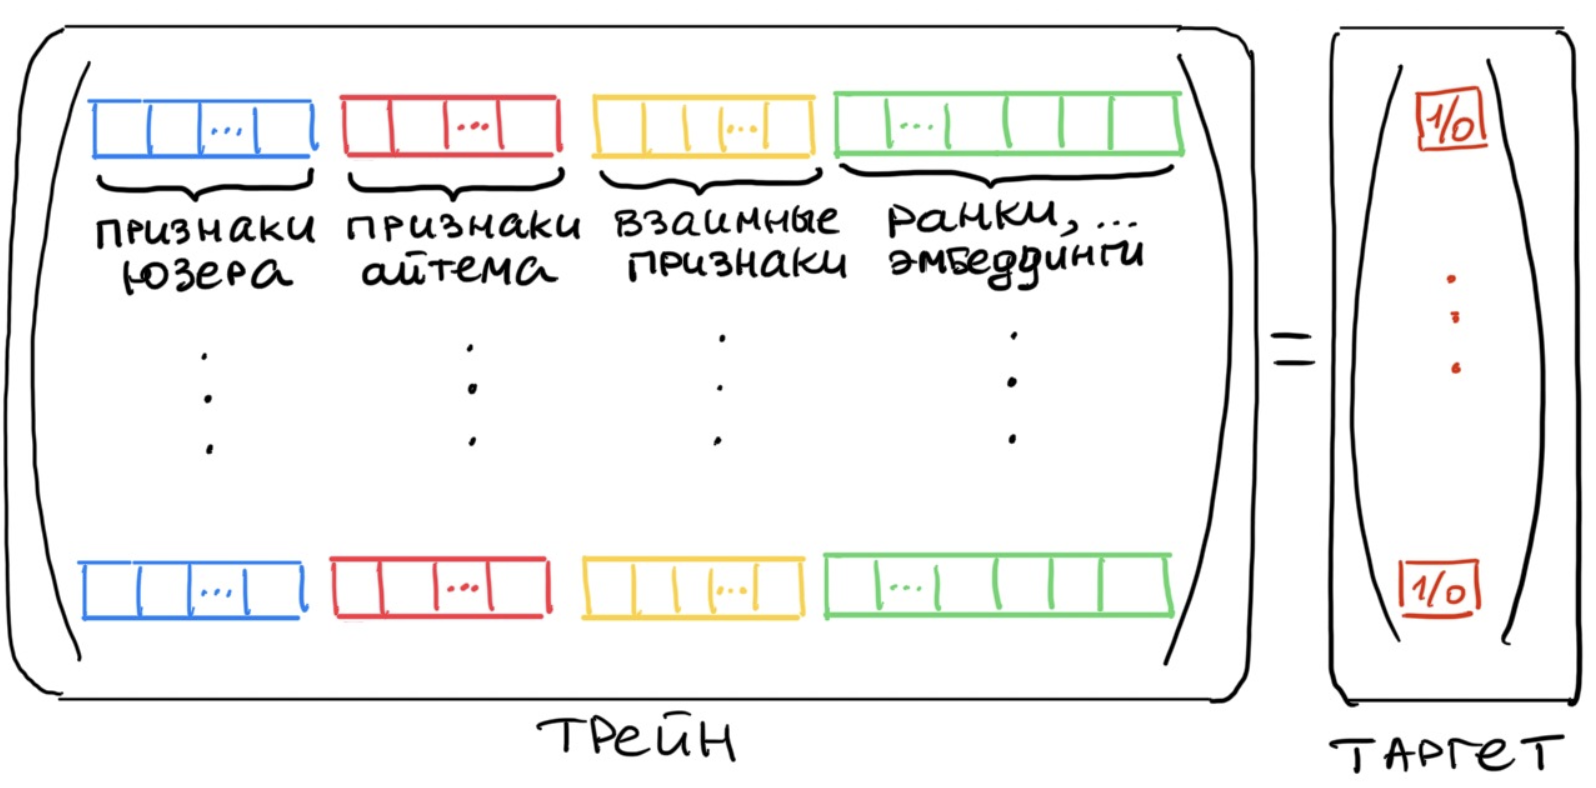

- We will treat this task as a binary classification problem
- We will use `CatBoostClassifier` because we're dealing with a lot of categorical variables

Construct train + target

`target = 1`. These are positive interactions, i.e. all the items among BPR candidates the user has actually watched

In [65]:
pos = candidates.merge(val,
                       on=['user_id', 'item_id'],
                       how='inner')

pos['target'] = 1
print(pos.shape)
pos.head()

(68184, 7)


user_id item_id  rank last_watch_dt  total_dur  watched_pct  target
0        2    9164     5    2021-06-23       6650        100.0       1
1        2    8482     6    2021-06-18       5886        100.0       1
2       30    9728    12    2021-06-21       8436        100.0       1
3       46   10440     5    2021-07-05       7449         20.0       1
4       60   15297    17    2021-07-24      14896         88.0       1

`target = 0`. These are negative interactions, i.e. all the items among BPR candidates the user has not watched

We will also add sampling to avoid severe class imbalance

In [66]:
neg = candidates.set_index(['user_id', 'item_id']).join(val.set_index(['user_id', 'item_id']))

In [67]:
neg = neg[neg['watched_pct'].isnull()].reset_index()

In [68]:
round(pos.shape[0] / neg.shape[0], 4)

0.0377

In [69]:
# use 1:2 share of positives to negatives

random.seed(77)
np.random.seed(77)

neg = neg.sample(pos.shape[0] * 2)
neg['target'] = 0

neg.shape

(136368, 7)

Next, split the val dataset into ctb_train and ctb_test sets.

! We will split based on users, not date.

`Why?`:

- Negative interactions don't have the date
- The boosting model should be able to handle cold users as well

In [70]:
ctb_train_users, ctb_test_users = train_test_split(val['user_id'].unique(),
                                                  random_state=8,
                                                  test_size=0.2)

In [71]:
# use 10% of the CatBoost train data for early stopping
ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                  random_state=9,
                                                  test_size=0.1)

In [72]:
select_col = ['user_id', 'item_id', 'rank', 'target']

# Catboost train
ctb_train = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_train_users)],
        neg[neg['user_id'].isin(ctb_train_users)]
        ])[select_col]
    )

# Catboost test
ctb_test = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_test_users)],
        neg[neg['user_id'].isin(ctb_test_users)]
        ])[select_col]
    )

# validation for early stopping
ctb_eval = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_eval_users)],
        neg[neg['user_id'].isin(ctb_eval_users)]
        ])[select_col]
    )

Check class distribution

In [73]:
ctb_train['target'].value_counts(normalize=True)

target
0    0.666563
1    0.333437
Name: proportion, dtype: float64

In [74]:
ctb_eval['target'].value_counts(normalize=True)

target
0    0.670358
1    0.329642
Name: proportion, dtype: float64

In [75]:
ctb_test['target'].value_counts(normalize=True)

target
0    0.665589
1    0.334411
Name: proportion, dtype: float64

As explained above, we will do only basic preprocessing as part of the baseline solution:

- select simple categorical features
- use the 1st level model's `rank` as a feature
- fill in missing values

In [76]:
user_col = ['user_id', 'age', 'income', 'sex', 'kids_flg']
item_col = ['item_id', 'content_type', 'countries', 'for_kids', 'age_rating', 'studios']

In [77]:
train_feat = (ctb_train
              .merge(users[user_col], on=['user_id'], how='left')
              .merge(items[item_col], on=['item_id'], how='left'))

eval_feat = (ctb_eval
             .merge(users[user_col], on=['user_id'], how='left')
             .merge(items[item_col], on=['item_id'], how='left'))

In [78]:
train_feat.head()

user_id item_id  rank  target        age         income  sex  kids_flg  \
0   333643    4567    23       0  age_45_54   income_40_60    Ж       0.0   
1    12838    2498    10       0  age_55_64   income_20_40    Ж       0.0   
2   817414    2301    18       0        NaN            NaN  NaN       NaN   
3    18971   15297    14       1  age_25_34  income_90_150    Ж       1.0   
4    70698    8784    25       1  age_25_34   income_60_90    М       1.0   

  content_type                     countries  for_kids  age_rating studios  
0       series                        Россия       NaN        16.0     NaN  
1         film               Россия, Армения       NaN        16.0     NaN  
2         film  Великобритания, США, Венгрия       NaN        16.0     NaN  
3       series                        Россия       NaN        18.0     NaN  
4       series                           США       NaN        16.0     NaN

In [79]:
drop_col = ['user_id', 'item_id']
target_col = ['target']
cat_col = ['age', 'income', 'sex', 'content_type', 'countries', 'studios']

In [80]:
X_train, y_train = train_feat.drop(drop_col + target_col, axis=1), train_feat[target_col]
X_val, y_val = eval_feat.drop(drop_col + target_col, axis=1), eval_feat[target_col]

In [81]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((147665, 10), (147665, 1), (16072, 10), (16072, 1))

In [82]:
# fillna for catboost with the most frequent value
X_train = X_train.fillna(X_train.mode().iloc[0])

In [83]:
# fillna for catboost with the most frequent value
X_val = X_val.fillna(X_train.mode().iloc[0])

In [84]:
X_train.head()

rank        age         income sex  kids_flg content_type  \
0    23  age_45_54   income_40_60   Ж       0.0       series   
1    10  age_55_64   income_20_40   Ж       0.0         film   
2    18  age_35_44   income_20_40   М       0.0         film   
3    14  age_25_34  income_90_150   Ж       1.0       series   
4    25  age_25_34   income_60_90   М       1.0       series   

                      countries  for_kids  age_rating                  studios  
0                        Россия       0.0        16.0  Warner Bros. Television  
1               Россия, Армения       0.0        16.0  Warner Bros. Television  
2  Великобритания, США, Венгрия       0.0        16.0  Warner Bros. Television  
3                        Россия       0.0        18.0  Warner Bros. Television  
4                           США       0.0        16.0  Warner Bros. Television

Train `CatBoostClassifier`

- no hyperparameter tuning
- use early_stopping to avoid overfitting

In [85]:
est_params = {
  'subsample': 0.9,
  'max_depth': 5,
  'n_estimators': 2000,
  'learning_rate': 0.01,
  'thread_count': 20,
  'random_state': 99,
  'verbose': 200,
}

ctb_model = CatBoostClassifier(**est_params)

In [86]:
ctb_model.fit(X_train,
              y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds=100,
              cat_features=cat_col,
              plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6901645	test: 0.6901255	best: 0.6901255 (0)	total: 259ms	remaining: 8m 36s
200:	learn: 0.5280588	test: 0.5256594	best: 0.5256594 (200)	total: 34.9s	remaining: 5m 12s
400:	learn: 0.5193547	test: 0.5167318	best: 0.5167318 (400)	total: 1m 13s	remaining: 4m 52s
600:	learn: 0.5166769	test: 0.5142427	best: 0.5142427 (600)	total: 1m 50s	remaining: 4m 16s
800:	learn: 0.5147383	test: 0.5125628	best: 0.5125628 (800)	total: 2m 27s	remaining: 3m 40s
1000:	learn: 0.5132837	test: 0.5113945	best: 0.5113945 (1000)	total: 3m 5s	remaining: 3m 5s
1200:	learn: 0.5123666	test: 0.5108265	best: 0.5108260 (1197)	total: 3m 41s	remaining: 2m 27s
1400:	learn: 0.5114689	test: 0.5102727	best: 0.5102727 (1400)	total: 4m 21s	remaining: 1m 51s
1600:	learn: 0.5108053	test: 0.5098911	best: 0.5098911 (1600)	total: 5m	remaining: 1m 14s
1800:	learn: 0.5102595	test: 0.5096228	best: 0.5096219 (1796)	total: 5m 40s	remaining: 37.6s
1999:	learn: 0.5098874	test: 0.5094901	best: 0.5094891 (1997)	total: 6m 22s	remaini

Plot feature importances

In [87]:
imp_catboost = pd.DataFrame(X_train.columns, columns=['feature'])
imp_catboost['importance'] = ctb_model.feature_importances_

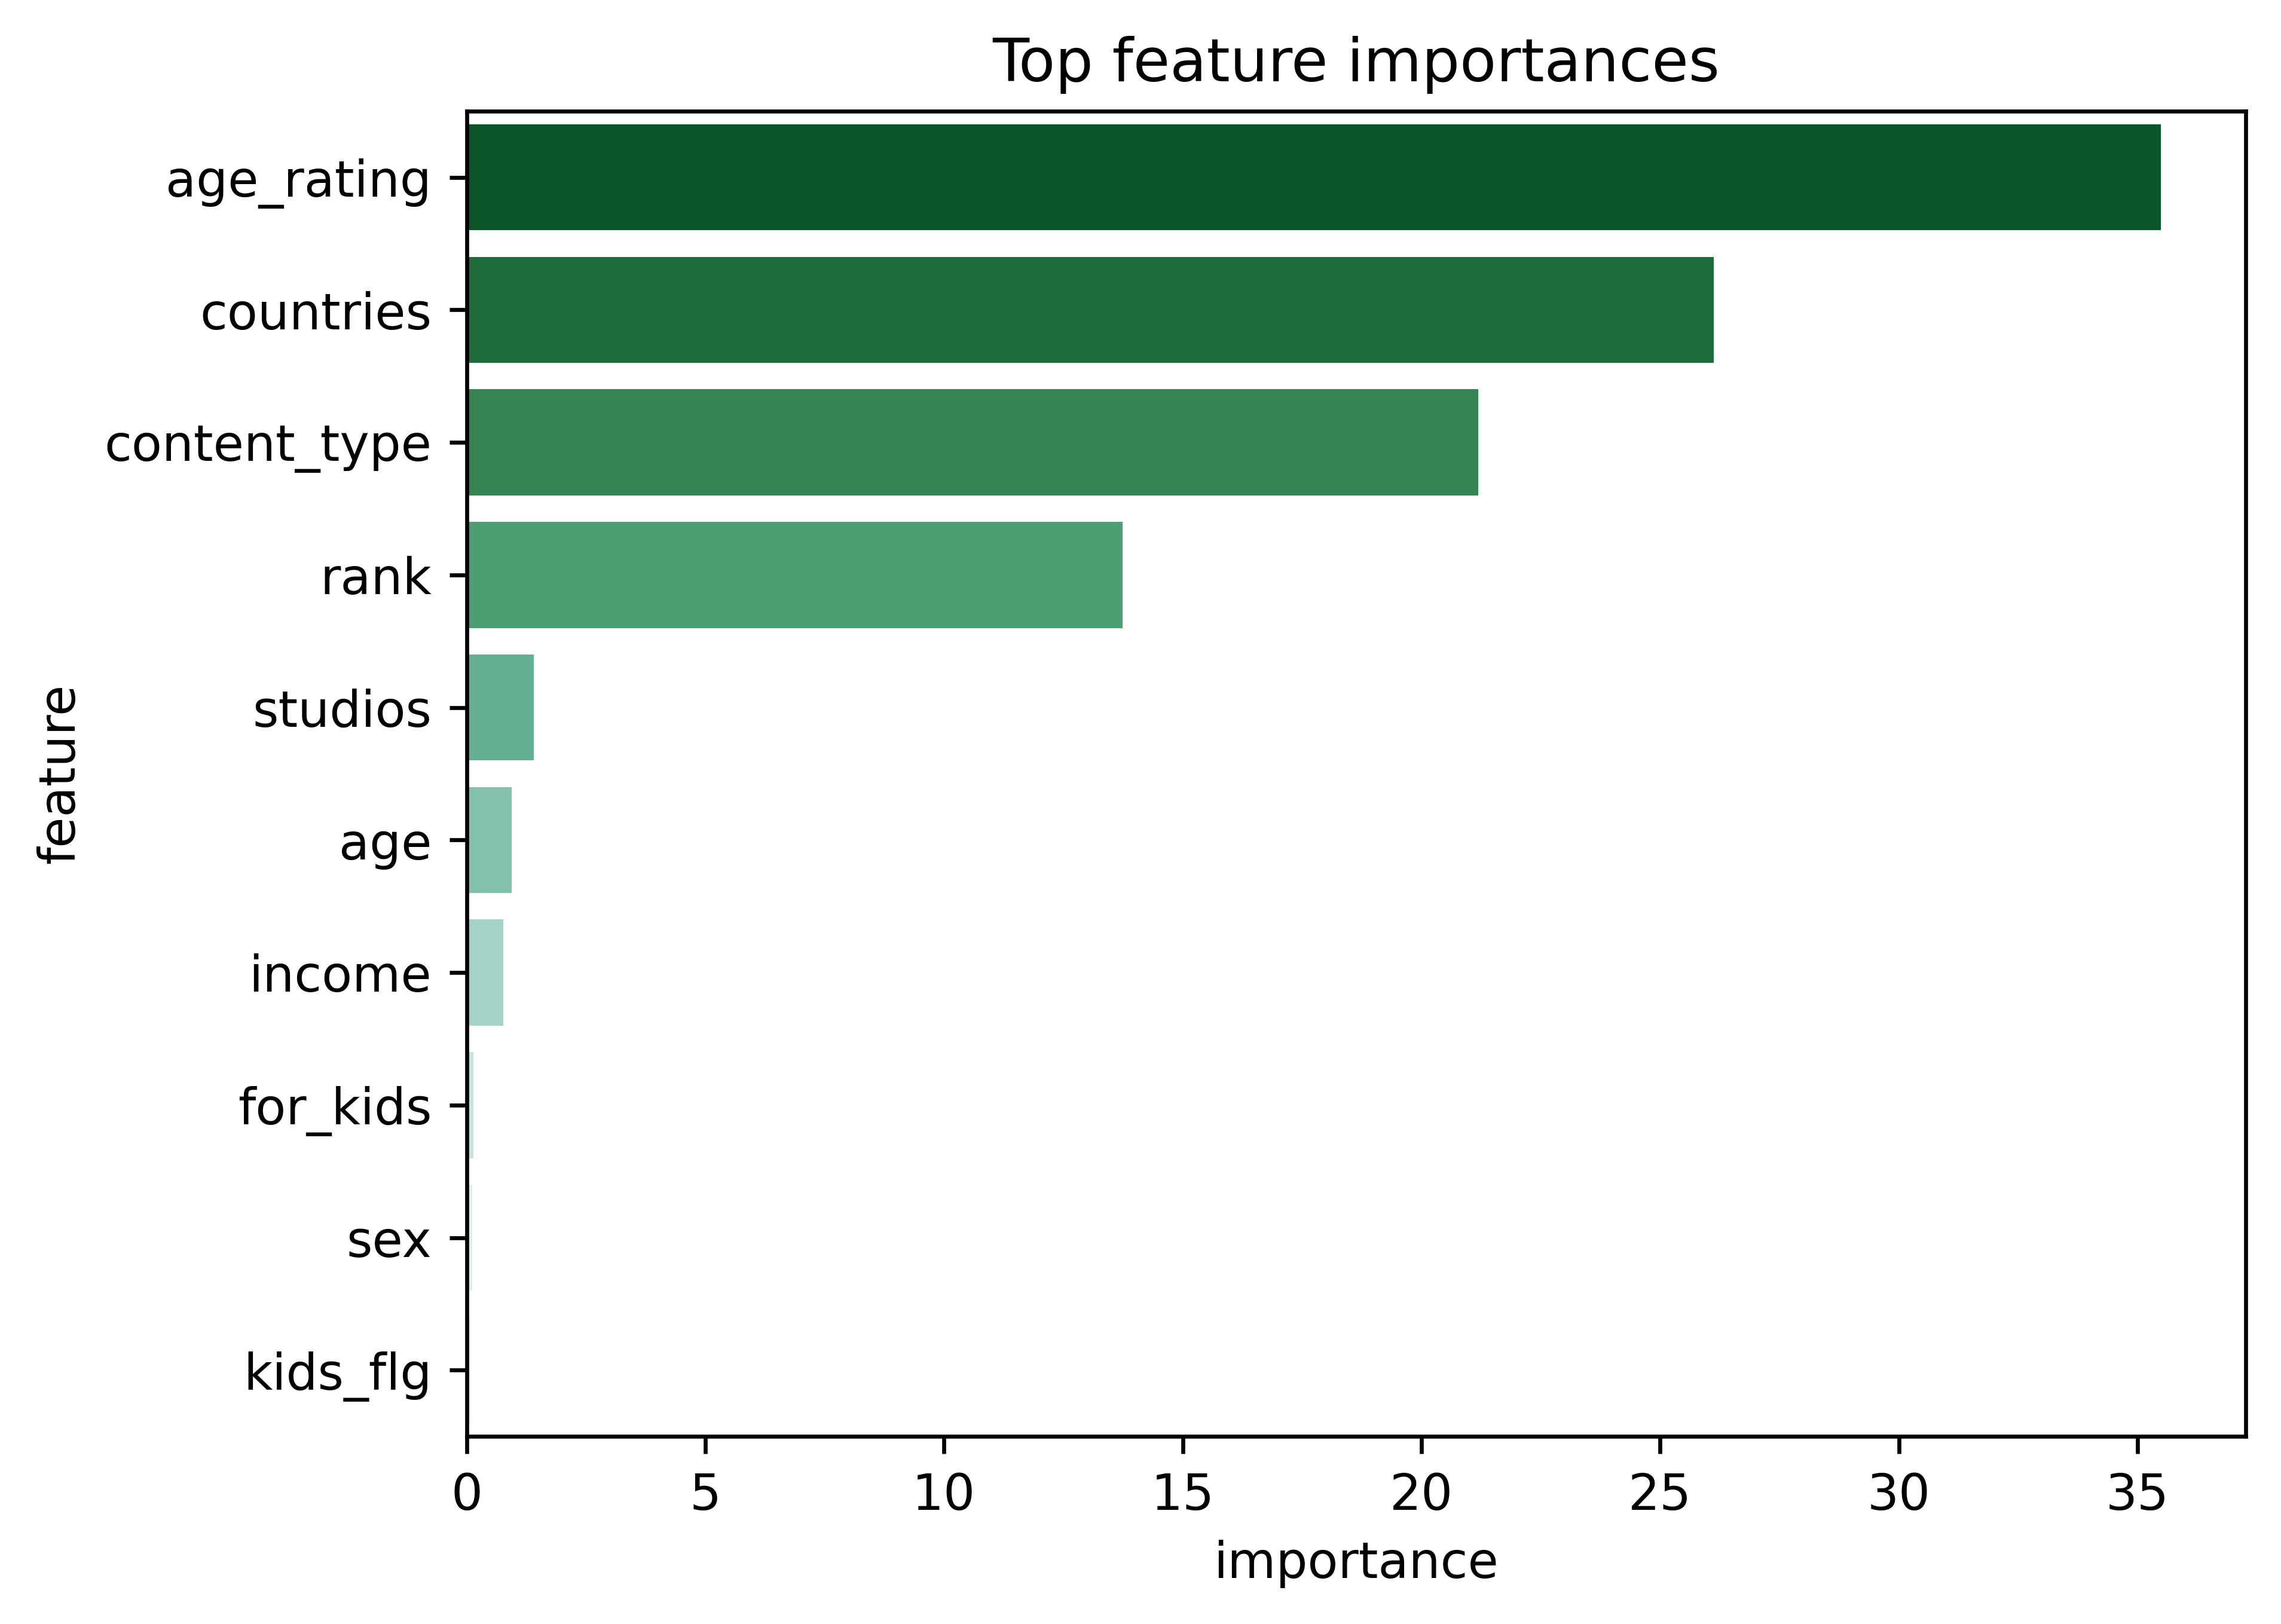

In [88]:
sns.barplot(data=imp_catboost.sort_values(by='importance', ascending=False), x='importance', y='feature', palette="BuGn_r")
plt.title('Top feature importances');

Estimate CatBoost quality

In [89]:
test_feat = (ctb_test
             .merge(users[user_col], on=['user_id'], how='left')
             .merge(items[item_col], on=['item_id'], how='left'))

In [90]:
# fillna for catboost with the most frequent value
test_feat = test_feat.fillna(X_train.mode().iloc[0])

In [91]:
X_test, y_test = test_feat.drop(drop_col + target_col, axis=1), test_feat['target']

In [92]:
X_test.head()

rank        age        income sex  kids_flg content_type  \
0    26  age_45_54  income_20_40   Ж       1.0       series   
1    30  age_25_34  income_20_40   Ж       0.0         film   
2    30  age_35_44  income_40_60   Ж       0.0         film   
3    28  age_45_54  income_20_40   Ж       1.0         film   
4    10  age_35_44  income_20_40   М       0.0         film   

                 countries  for_kids  age_rating                  studios  
0                   Россия       0.0        18.0  Warner Bros. Television  
1                      США       0.0        12.0  Warner Bros. Television  
2                      США       0.0        12.0  Warner Bros. Television  
3  Великобритания, Франция       0.0         0.0  Warner Bros. Television  
4                  Франция       0.0         6.0  Warner Bros. Television

In [93]:
y_pred = ctb_model.predict_proba(X_test)

In [94]:
f"CasBoost test ROC AUC score = {roc_auc_score(y_test, y_pred[:, 1]):.2f}"

'CasBoost test ROC AUC score = 0.78'

## Estimate quality on the global test

- Generate predictions using the BPR model
- Generate predictions using the two-stage model (BPR + Catboost)
- Compare the quality based on the precision@20, recall@20 and mrr@20 metrics

In [95]:
test_model_metrics = pd.DataFrame(columns=['Model', 'Recall@K', 'Precision@K', 'MRR'])

1) BPR model quality calculation

In [96]:
# exclude cold users from the global test set
test = test[test['user_id'].isin(val['user_id'].unique())]

We will take a slice of the whole test set due to memory constraints during the evaluation of the improved model later on.

In [97]:
SEED = 89
N = 8000

sampled_users = (test['user_id']
                 .drop_duplicates()
                 .sample(n=N, random_state=SEED)
                 .tolist())

test = test[test['user_id'].isin(sampled_users)]

In [98]:
test_user_history = test.groupby('user_id')[['item_id']].agg(lambda x: list(x))
k = 30
test_users = test.user_id.unique()
items_bpr, values_bpr = algo.recommend(test_users, train_sparse[test_users], N=k, filter_already_liked_items=True)
pred_bpr = pd.DataFrame({
    "user_id": test_users,
    "preds": items_bpr.tolist()
})
pred_bpr = test_user_history.merge(pred_bpr, how='left', on='user_id')

In [99]:
test_bpr_metrics = pd.DataFrame([{'Model': 'BPR baseline', 'Recall@K': recall(pred_bpr, k=20), 'Precision@K': precision(pred_bpr, k=20), 'MRR': mrr(pred_bpr, k=20)}])

2) two-stage model quality calculation

In [100]:
# generate predictions

pred_bpr = pred_bpr[['user_id', 'preds']]
pred_bpr = pred_bpr.explode('preds').rename(columns={'preds': 'item_id'})
pred_bpr['rank'] = pred_bpr.groupby('user_id').cumcount() + 1

pred_bpr.head()

user_id item_id  rank
0       30    1465     1
0       30   14512     2
0       30   13865     3
0       30   15221     4
0       30   14901     5

In [101]:
pred_bpr_ctb = pred_bpr.copy()

# add features to the global test set
score_feat = (pred_bpr_ctb
              .merge(users[user_col], on=['user_id'], how='left')
              .merge(items[item_col], on=['item_id'], how='left'))

# fillna for catboost with the most frequent value
score_feat = score_feat.fillna(X_train.mode().iloc[0])

In [102]:
score_feat.head()

user_id item_id  rank        age        income sex  kids_flg content_type  \
0       30    1465     1  age_35_44  income_20_40   М       0.0       series   
1       30   14512     2  age_35_44  income_20_40   М       0.0         film   
2       30   13865     3  age_35_44  income_20_40   М       0.0         film   
3       30   15221     4  age_35_44  income_20_40   М       0.0         film   
4       30   14901     5  age_35_44  income_20_40   М       0.0         film   

         countries  for_kids  age_rating                  studios  
0           Россия       0.0        18.0  Warner Bros. Television  
1           Россия       0.0        12.0  Warner Bros. Television  
2           Россия       0.0        12.0  Warner Bros. Television  
3  Франция, Италия       0.0        12.0  Warner Bros. Television  
4         Германия       0.0        16.0  Warner Bros. Television

In [103]:
# catboost predict_proba
ctb_prediction = ctb_model.predict_proba(score_feat.drop(drop_col, axis=1, errors='ignore'))

pred_bpr_ctb['ctb_pred'] = ctb_prediction[:, 1]
pred_bpr_ctb.head(3)

user_id item_id  rank  ctb_pred
0       30    1465     1  0.810609
0       30   14512     2  0.678199
0       30   13865     3  0.635034

In [104]:
# sort by predicted CatBoost score for each user and assign a new rank
pred_bpr_ctb = pred_bpr_ctb.sort_values(by=['user_id', 'ctb_pred'], ascending=[True, False])
pred_bpr_ctb['rank_ctb'] = pred_bpr_ctb.groupby('user_id').cumcount() + 1

In [105]:
pred_bpr_ctb.head(10)

user_id item_id  rank  ctb_pred  rank_ctb
0       30   10440     9  0.860078         1
0       30    1465     1  0.810609         2
0       30    4151    19  0.778767         3
0       30   14512     2  0.678199         4
0       30   13865     3  0.635034         5
0       30    9728    12  0.594819         6
0       30   16201     8  0.321453         7
0       30    3449    14  0.300375         8
0       30   16447     6  0.297314         9
0       30     142    10  0.288768        10

Final two-stage model quality estimation

In [106]:
true_items = test.groupby('user_id').agg(lambda x: list(x))[['item_id']].reset_index()
pred_items = pred_bpr_ctb.groupby('user_id').agg(lambda x: list(x))[['item_id']].reset_index().rename(columns={'item_id': 'preds'})
true_pred_items = true_items.merge(pred_items, how='left')

In [107]:
true_pred_items.head()

user_id                                            item_id  \
0       30                                 [4181, 8584, 8636]   
1      106  [337, 1439, 2808, 2836, 5411, 6267, 10544, 128...   
2      321                                             [8335]   
3      571              [212, 3071, 3102, 8605, 12132, 14461]   
4      753                                 [3449, 7597, 9327]   

                                               preds  
0  [10440, 1465, 4151, 14512, 13865, 9728, 16201,...  
1  [14942, 9506, 11985, 9336, 10323, 15196, 13955...  
2  [11268, 3386, 8893, 5716, 4774, 6561, 9207, 55...  
3  [6050, 4976, 7401, 9585, 3071, 3553, 4400, 484...  
4  [12055, 6410, 7549, 8822, 4912, 7291, 2682, 15...

In [108]:
test_bpr_ctb_metrics = pd.DataFrame([{'Model': 'BPR+Catboost baseline', 'Recall@K': recall(true_pred_items, k=20), 'Precision@K': precision(true_pred_items, k=20), 'MRR': mrr(true_pred_items, k=20)}])

# Improved two-stage model

In this section we will try to improve the quality on the global test set by creating a new model, including:

- ensemble of three 1st level models
- advanced feature engineering
- hyperparameter tuning

We will exclude cold users from the validation set

In [111]:
val = val[val['user_id'].isin(train['user_id'].unique())]

In [112]:
val.reset_index(drop=True, inplace=True)

In [113]:
val.head()

item_id  user_id last_watch_dt  total_dur  watched_pct
0        0   184560    2021-07-18      13278         50.0
1        0   379871    2021-07-04       4279          3.0
2        0   427911    2021-08-11       5363         38.0
3        0   573405    2021-08-01      10164          9.0
4        0   968581    2021-08-04       7310          6.0

In [114]:
train["watched_pct"] = train["watched_pct"].fillna(0)

In [115]:
values = train.watched_pct.values
rows = train.user_id.values
cols = train.item_id.values

train_sparse = sparse.csr_matrix((values, (rows, cols)))

In [116]:
train_sparse.shape

(1097517, 16512)

## Stage 1 models

We will train three stage-one models and tune their hyperparameters to find the best combination based on precision@k:

- BPR
- ItemKNN
- ALS

Write a function that creates an optuna study depending on the model and searches for the best hyperparameters while optimizing the selected metric:

In [117]:
def evaluate(model, train_mat, val_df, n=30):

    users = val_df['user_id'].unique()

    recs, _ = model.recommend(users, train_mat[users], N=n, filter_already_liked_items=True)

    user_hist = val_df.groupby('user_id')['item_id'].apply(list).reset_index()
    df_preds = pd.DataFrame({'user_id': users, 'preds': list(recs)})
    df = user_hist.merge(df_preds, on='user_id', how='left')

    return precision(df, k=n)

def make_tuner(model_name: str, n_trials: int = 30, seed: int = 97):

    """
    Create an optuna study for one of the three models: BPR, ALS, ItemKNN
    """

    def objective(trial: optuna.Trial, seed=seed) -> float:

        if model_name == 'BPR':

            factors = trial.suggest_int('factors', 20, 100)
            reg = trial.suggest_loguniform('reg', 1e-3, 1.0)
            iters = trial.suggest_int('iters', 10, 100)

            model = implicit.bpr.BayesianPersonalizedRanking(
                factors=factors,
                regularization=reg,
                iterations=iters,
                use_gpu=False,
                random_state=seed
            )
            model.fit(train_sparse.astype('double'))

        elif model_name == 'ALS':

            factors = trial.suggest_int('factors', 20, 100)
            reg = trial.suggest_loguniform('reg', 1e-3, 1.0)
            iters = trial.suggest_int('iters', 10, 100)

            model = AlternatingLeastSquares(
                factors=factors,
                regularization=reg,
                iterations=iters,
                use_gpu=False
            )
            model.fit(train_sparse.astype('double'))

        elif model_name == "ItemKNN":

            K = trial.suggest_int('K', 5, 30)

            model = ItemItemRecommender(K=K)
            model.fit(train_sparse.astype('double'), show_progress=False)

        else:
            raise ValueError(f"Unknown model: {model_name}")

        # evaluate precision@K on val set
        return evaluate(model, train_sparse, val)

    study = optuna.create_study(study_name=f"{model_name}_study",
                                direction="maximize",
                                sampler=optuna.samplers.TPESampler(seed=seed),
                                pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
                                )
    study.optimize(objective, n_trials=n_trials)
    return study

In [118]:
# Write a function that uses a 1st level model to predict on a given set of data and returns recommendations and metrics
def get_stage_one_preds(train_sparse, test_df, model, k):

    users = test_df.user_id.unique()
    items, values = model.recommend(users, train_sparse[users], N=k, filter_already_liked_items=True)

    test_user_history = test_df.groupby('user_id')[['item_id']].agg(lambda x: list(x))
    model_preds = pd.DataFrame({"user_id": users, "preds": items.tolist()})
    model_preds = test_user_history.merge(model_preds, how='left', on='user_id')
    model_metrics = pd.DataFrame([{'Model': model.__class__.__name__, 'Recall@K': recall(model_preds), 'Precision@K': precision(model_preds), 'MRR': mrr(model_preds)}])

    return model_preds, model_metrics


In [119]:
# function to process 1st level model preds into a df where each row contains user_id, item_id and item's rank
def get_ranks(preds):
    candidates = preds[['user_id', 'preds']]
    candidates = candidates.explode('preds').rename(columns={'preds': 'item_id'})
    candidates = candidates[candidates['item_id']!=-1].reset_index(drop=True) # for itemKNN
    candidates['rank'] = candidates.groupby('user_id').cumcount() + 1
    return candidates

In [120]:
# bpr_study = make_tuner("BPR", n_trials=30)
# als_study = make_tuner("ALS", n_trials=30)
# knn_study = make_tuner("ItemKNN", n_trials=30)

In [121]:
# print("BPR best:", bpr_study.best_trial.params, "Metric", bpr_study.best_value)
# print("ALS best:", als_study.best_trial.params, "Metric", als_study.best_value)
# print("KNN best:", knn_study.best_trial.params, "Metric", knn_study.best_value)

In [122]:
# BPR best: {'factors': 36, 'reg': 0.008935114595095144, 'iters': 31} Metric 0.1397
# ALS best: {'factors': 20, 'reg': 0.0011106102703935374, 'iters': 100} Metric 0.1865
# KNN best: {'K': 26} Metric 0.1624

In [123]:
# best_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=36,
#                                                     regularization=0.008935114595095144,
#                                                     iterations=31,
#                                                     use_gpu=False,
#                                                     random_state=97)
# best_bpr.fit(train_sparse.astype("double"))

# best_als = AlternatingLeastSquares(factors=20,
#                                    regularization=0.0011106102703935374,
#                                    iterations=100,
#                                    use_gpu=False)
# best_als.fit(train_sparse.astype("double"))

# best_knn = ItemItemRecommender(K=26)
# best_knn.fit(train_sparse.astype("double"), show_progress=False)

In [124]:
# best_bpr.save(f"{MAIN_PATH}models/bpr_model.npz")
# best_als.save(f"{MAIN_PATH}models/als_model.npz")
# best_knn.save(f"{MAIN_PATH}models/knn_model.npz")

In [125]:
best_bpr = implicit.bpr.BayesianPersonalizedRanking().load(f"{MAIN_PATH}models/bpr_model.npz")
best_als = AlternatingLeastSquares().load(f"{MAIN_PATH}models/als_model.npz")
best_knn = ItemItemRecommender().load(f"{MAIN_PATH}models/knn_model.npz")

In [126]:
k = 30
bpr_preds, bpr_metrics = get_stage_one_preds(train_sparse, val, best_bpr, k)
als_preds, als_metrics = get_stage_one_preds(train_sparse, val, best_als, k)
knn_preds, knn_metrics = get_stage_one_preds(train_sparse, val, best_knn, k)

In [127]:
stage_one_val_metrics = pd.concat([bpr_metrics, als_metrics, knn_metrics])

In [128]:
stage_one_val_metrics

Model  Recall@K  Precision@K     MRR
0  BayesianPersonalizedRanking    0.1386       0.1402  0.1851
0      AlternatingLeastSquares    0.1838       0.1859  0.2213
0          ItemItemRecommender    0.1604       0.1624  0.2528

In [129]:
bpr_candidates = get_ranks(bpr_preds)
als_candidates = get_ranks(als_preds)
knn_candidates = get_ranks(knn_preds)

In [130]:
bpr_df = bpr_candidates.rename(columns={'rank':'bpr_rank'})
als_df = als_candidates.rename(columns={'rank':'als_rank'})
knn_df = knn_candidates.rename(columns={'rank':'knn_rank'})

In [131]:
dfs = [bpr_df, als_df, knn_df]
merged_candidates = reduce(lambda left, right: pd.merge(left, right, on=['user_id','item_id'], how='outer'), dfs)

In [132]:
# fillna with current max rank
merged_candidates.fillna(merged_candidates[['bpr_rank', 'als_rank', 'knn_rank']].max().max(), inplace=True)

In [133]:
merged_candidates.head()

user_id item_id  bpr_rank  als_rank  knn_rank
0        2      85       6.0      30.0      30.0
1        2     142      30.0      30.0      17.0
2        2     565      23.0       6.0      30.0
3        2     682      30.0      30.0      30.0
4        2     945      27.0      30.0      30.0

## Feature Engineering

Now we will train a stage-two boosting model using the 1st level predictions and also throw in additional features to try and improve the baseline quality.

First, we will generate title and description text embeddings using a pre-trained model for all the items we have and save the corresponding item IDs and numeric values. Since the model has been pre-trained on a separate corpus, we can safely use it both for train and test.

In [134]:
items.head()

item_id content_type                 title      title_orig  release_year  \
0    10711         film        Поговори с ней  Hable con ella        2002.0   
1     2508         film           Голые перцы    Search Party        2014.0   
2    10716         film      Тактическая сила  Tactical Force        2011.0   
3     7868         film                45 лет        45 Years        2015.0   
4    16268         film  Все решает мгновение             NaN        1978.0   

                                             genres       countries  for_kids  \
0           драмы, зарубежные, детективы, мелодрамы         Испания       NaN   
1                  зарубежные, приключения, комедии             США       NaN   
2  криминал, зарубежные, триллеры, боевики, комедии          Канада       NaN   
3                      драмы, зарубежные, мелодрамы  Великобритания       NaN   
4                драмы, спорт, советские, мелодрамы            СССР       NaN   

   age_rating   studios         directors  \
0        16.0       NaN  Педро Альмодовар   
1        16.0       NaN    Скот Армстронг   
2        16.0       NaN  Адам П. Калтраро   
3        16.0       NaN         Эндрю Хэй   
4        12.0  Ленфильм  Виктор Садовский   

                                              actors  \
0  Адольфо Фернандес, Ана Фернандес, Дарио Гранди...   
1  Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...   
2  Адриан Холмс, Даррен Шалави, Джерри Вассерман,...   
3  Александра Риддлстон-Барретт, Джеральдин Джейм...   
4  Александр Абдулов, Александр Демьяненко, Алекс...   

                                         description  \
0  Мелодрама легендарного Педро Альмодовара «Пого...   
1  Уморительная современная комедия на популярную...   
2  Профессиональный рестлер Стив Остин («Все или ...   
3  Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...   
4  Расчетливая чаровница из советского кинохита «...   

                                            keywords  
0  Поговори, ней, 2002, Испания, друзья, любовь, ...  
1  Голые, перцы, 2014, США, друзья, свадьбы, прео...  
2  Тактическая, сила, 2011, Канада, бандиты, ганг...  
3  45, лет, 2015, Великобритания, брак, жизнь, лю...  
4  Все, решает, мгновение, 1978, СССР, сильные, ж...

In [135]:
items['title'].isna().sum()

np.int64(0)

In [136]:
items['description'].isna().sum()

np.int64(2)

In [137]:
items['description'] = items['description'].fillna("")

In [138]:
# create a single column that consists of title + movie description

items['title_description'] = items["title"].str.strip() + ". " + items["description"].str.strip()

In [139]:
len(items) == items['item_id'].nunique()

True

In [140]:
# text_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

In [141]:
# texts = items["title_description"].tolist()
# text_embeddings = text_model.encode(texts,
#                                     batch_size=32,
#                                     max_length=256,
#                                     truncation=True,
#                                     show_progress_bar=True,
#                                     normalize_embeddings=True)

In [142]:
# save for later use as CatBoost features
# emb_df = pd.DataFrame(text_embeddings,
#                       index=items["item_id"].values,
#                       columns=[f"emb_{i}" for i in range(text_embeddings.shape[1])])

In [143]:
# emb_df.to_pickle("title_description_embeddings.pkl")

In [144]:
title_description_embeddings = pd.read_pickle(f"{MAIN_PATH}embeddings/title_description_embeddings.pkl")

Next, we will pre-compute other item and user features for future use. **Important note: since I'm not using any information derived from interactions to build these features, no leakage happens here and such features as title embeddings, release year buckets, one-hot genres, etc. can be safely precomputed on all the items before splitting into train, validation and test sets.**

In contrast, any features that will use statistical information and interactions will be computed only on the train set later on.

- content_type

In [145]:
items['content_type'].isna().sum()

np.int64(0)

In [146]:
items['content_type'].value_counts()

content_type
film      12002
series     3961
Name: count, dtype: int64

We will use content_type without any additional preprocessing.

- for_kids

In [147]:
items['for_kids'].isna().sum()

np.int64(15397)

In [148]:
items['for_kids'].value_counts()

for_kids
0.0    452
1.0    114
Name: count, dtype: int64

Seeing that this feature has too many NaNs and few 1.0 values and showed a very low feature importance on the baseline, we can probably drop it.

- age_rating

In [149]:
items['age_rating'].isna().sum()

np.int64(2)

In [150]:
items['age_rating'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 15963 entries, 0 to 15962
Series name: age_rating
Non-Null Count  Dtype  
--------------  -----  
15961 non-null  float64
dtypes: float64(1)
memory usage: 124.8 KB


In [151]:
items['age_rating'].value_counts()

age_rating
16.0    5729
12.0    4147
18.0    2547
6.0     1538
0.0     1518
21.0     482
Name: count, dtype: int64

In [152]:
for desc in items[items['age_rating'].isna()]['description']:
  print(desc)

Маленькие мальчики всего мира любят играть в машинки, но что они знают о «взрослых» прототипах своих любимцев? Познавательный мультсериал «Машины-помощники» знакомит малышей с разными видами четырехколесных друзей современного человека. Стоит кому-нибудь серьезно заболеть или пораниться, как на работу выходит «Скорая помощь». Если она спешит на вызов, то на ее крыше загорается проблесковый маячок. Такое же устройство мигает на пожарной машине – воительнице с неуправляемым огнем. Ответственную работу выполняет и полицейский автомобиль, патрулирующий город. На выручку своим собратьям на колесах, которые сломались и не могут продолжать поездку, приходит эвакуатор. За чистоту дорог стоит поблагодарить уборочную машину, а за новые постройки – экскаваторы, самосвалы, автовозы, бетономешалку. Маленькие зрители убедятся, что машины для взрослых – не игрушки. Каждое транспортное средство выполняет ответственную работу. Впрочем, в свободное время они не против развлечься – поучаствовать в гонках

We will fill in missing age ratings with 0 category.

In [153]:
items['age_rating'] = items['age_rating'].fillna(0.0)

- release_year

In [154]:
items['release_year'].isna().sum()

np.int64(98)

In [155]:
items['release_year'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 15963 entries, 0 to 15962
Series name: release_year
Non-Null Count  Dtype  
--------------  -----  
15865 non-null  float64
dtypes: float64(1)
memory usage: 124.8 KB


In [156]:
items['release_year'].value_counts().iloc[:20]

release_year
2020.0    1717
2019.0    1328
2018.0    1288
2017.0    1039
2016.0     947
2015.0     905
2013.0     812
2014.0     799
2012.0     657
2011.0     579
2021.0     461
2010.0     434
2009.0     367
2008.0     331
2007.0     313
2006.0     266
2004.0     185
2005.0     184
2003.0     152
2001.0     140
Name: count, dtype: int64

In [157]:
items[items['release_year'].isna()]['genres'].value_counts()

genres
фитнес                                                                                  61
футбол                                                                                  22
фитнес, спорт                                                                           12
зарубежные, детские песни, развитие, для детей                                           1
зарубежные, для детей, западные мультфильмы, развитие                                    1
для детей, хочу всё знать, детские песни, зарубежные, развитие, западные мультфильмы     1
Name: count, dtype: int64

The release years for fitness and football categories are probably not that important so we can fill NaNs with any value we choose, for example the global mode.

In [158]:
items['release_year'] = items['release_year'].fillna(items['release_year'].mode().iloc[0])

Next, we will generate two new features from release_year: movie_age and movie_era.

In [159]:
current_year = items['release_year'].max()

In [160]:
items['movie_age'] = current_year - items['release_year']

In [161]:
bins = [items['release_year'].min(), 1950, 1970, 1990, 2000, 2010, items['release_year'].max()]
labels = ['<1950','50–70','70–90','90–00','00–10','10–now']
items['movie_era'] = pd.cut(items['release_year'], bins=bins, labels=labels)

In [162]:
items['movie_era'].value_counts()

movie_era
10–now    10630
00–10      2507
70–90      1324
90–00       664
50–70       574
<1950       263
Name: count, dtype: int64

- Top genres

We will use only top N genres to avoid noise. Because each movie may contain multiple genres, we will use one-hot encoded features.

In [163]:
top_genres = [i[0] for i in most_common_cat(items, 'genres', n=20)]

In [164]:
top_genres

['драмы',
 'комедии',
 'зарубежные',
 'мелодрамы',
 'триллеры',
 'русские',
 'приключения',
 'боевики',
 'документальное',
 'криминал',
 'детективы',
 'фантастика',
 'семейное',
 'ужасы',
 'фэнтези',
 'для детей',
 'советские',
 'военные',
 'для взрослых',
 'биография']

In [165]:
items['genres'].isna().sum()

np.int64(0)

In [166]:
items['genre_list'] = (items['genres'].str.lower().str.split(',').apply(lambda lst: [g.strip() for g in lst if g.strip()]))

In [167]:
for g in top_genres:
    items[f'genre_{g}'] = items['genre_list'].apply(lambda lst: int(g in lst))

items.drop(columns=['genre_list'], inplace=True)

- Top countries

Same principle: select top countries and one-hot encode

In [168]:
top_countries = [i[0] for i in most_common_cat(items, 'countries', n=15)]

In [169]:
top_countries

['США',
 'Россия',
 'Франция',
 'СССР',
 'Великобритания',
 'Канада',
 'Германия',
 'Украина',
 'Италия',
 'Испания',
 'Республика Корея',
 'Швеция',
 'Япония',
 'Австралия',
 'Бельгия']

In [170]:
items['countries'].isna().sum()

np.int64(37)

In [171]:
# These contain only Russian titles and mostly fall into the fitness/sports category so they are probably made in Russia
mask = items['countries'].isna() & items['title_orig'].isna()
items.loc[mask, 'countries'] = 'Россия'

# Everything else will be marked as "Неизвестно"
items['countries'] = items['countries'].fillna('Неизвестно')

In [172]:
items['countries'].isna().sum()

np.int64(0)

In [173]:
items['country_list'] = (items['countries'].str.split(',').apply(lambda lst: [c.strip() for c in lst if c.strip()]))

In [174]:
for c in top_countries:
    items[f'country_{c}'] = items['country_list'].apply(lambda lst: int(c in lst))

items.drop(columns=['country_list'], inplace=True)

- Top studios

In [175]:
items['studios'].isna().sum()

np.int64(14898)

In [176]:
most_common_cat(items, 'studios', n=5)

[('HBO', 355),
 ('Ленфильм', 258),
 ('Sony Pictures', 164),
 ('рентв', 52),
 ('Paramount', 46)]

The 'studios' column contains a lot of NaNs and the rest of the values have little representation. However, I think we can extract the top 3 studios like HBO, Ленфильм, and Sony Pictures and use them as one-hot encoded features.

In [177]:
top_studios = [i[0] for i in most_common_cat(items, 'studios', n=3)]

In [178]:
top_studios

['HBO', 'Ленфильм', 'Sony Pictures']

In [179]:
items['studios'] = items['studios'].fillna('Неизвестно')

In [180]:
items['studios_list'] = (items['studios'].str.split(',').apply(lambda lst: [s.strip() for s in lst if s.strip()]))

In [181]:
for s in top_studios:
    items[f'studio_{s}'] = items['studios_list'].apply(lambda lst: int(s in lst))

items.drop(columns=['studios_list'], inplace=True)

- Top actors

In [182]:
items['actors'].isna().sum()

np.int64(2619)

In [183]:
most_common_cat(items, 'actors', n=50)

[('Николас Кейдж', 59),
 ('Сергей Никоненко', 58),
 ('Армен Джигарханян', 55),
 ('Лев Дуров', 54),
 ('Брюс Уиллис', 53),
 ('Сэмюэл Л. Джексон', 51),
 ('Роберт Де Ниро', 51),
 ('Раиса Рязанова', 50),
 ('Андрей Мерзликин', 50),
 ('Тимофей Трибунцев', 49),
 ('Ирина Розанова', 49),
 ('Игорь Ясулович', 48),
 ('Алексей Серебряков', 48),
 ('Евгений Евстигнеев', 47),
 ('Сергей Гармаш', 47),
 ('Ян Цапник', 46),
 ('Юрий Назаров', 46),
 ('Леонид Куравлёв', 45),
 ('Дж.К. Симмонс', 45),
 ('Андрей Смоляков', 45),
 ('Стэнли Туччи', 45),
 ('Дмитрий Суржиков', 44),
 ('Гоша Куценко', 44),
 ('Екатерина Васильева', 43),
 ('Борис Щербаков', 43),
 ('Александр Пашков', 42),
 ('Сергей Маковецкий', 42),
 ('Мария Куликова', 42),
 ('Диомид Виноградов', 42),
 ('Георгий Вицин', 42),
 ('Михаил Пуговкин', 42),
 ('Антонио Бандерас', 41),
 ('Уиллем Дефо', 41),
 ('Морган Фриман', 41),
 ('Татьяна Догилева', 41),
 ('Джон Гудман', 40),
 ('Татьяна Пельтцер', 39),
 ('Валентин Гафт', 39),
 ('Роман Мадянов', 39),
 ('Фрэнк Уэл

We will not use actor-based OHE features because of too many unique values. Each actor comprises a very small part of the dataset. Instead, we will generate a binary variable that tells us if a movie has any of the top 50 actors in it.

In [184]:
top_actors = [i[0] for i in most_common_cat(items, 'actors', n=50)]

In [185]:
items['actors'] = items['actors'].fillna('Неизвестно')

In [186]:
items['actors_list'] = (items['actors'].str.split(',').apply(lambda lst: [a.strip() for a in lst if a.strip()]))

In [187]:
items[f'top_actor'] = items['actors_list'].apply(lambda lst: int(any(a in top_actors for a in lst)))
items.drop(columns=['actors_list'], inplace=True)

In [188]:
items['top_actor'].value_counts()

top_actor
0    14146
1     1817
Name: count, dtype: int64

- Top directors

In [189]:
most_common_cat(items, 'directors', n=10)

[('Оливье Шиабоду', 511),
 ('Денис Марти', 58),
 ('Денис Франческо', 49),
 ('Антонио Адамо', 44),
 ('Кови', 40),
 ('Глова Роман Юрьевич', 36),
 ('Роман', 34),
 ('Газзман', 32),
 ('Сергей Зарев', 30),
 ('Франческо Фанелли', 30)]

One director seems particularly popular so we can create a binary variable with that name.

In [190]:
items['OlivierChiabodo'] = np.where(items['directors']=='Оливье Шиабоду', 1, 0)

In [191]:
items['OlivierChiabodo'].value_counts()

OlivierChiabodo
0    15452
1      511
Name: count, dtype: int64

Next, we will preprocess the 'keywords' column by cleaning it for tf-idf. We will store the cleaned texts similar to embeddings but we will train a tf-idf model on train later and predict on validation and test.

In [192]:
nlp = spacy.load("ru_core_news_md", disable=["parser"])

In [193]:
RU_STOPWORDS = nlp.Defaults.stop_words

In [194]:
def clean_keywords(text: str) -> list[str]:

    # lower case -> remove digits -> remove proper nouns -> lemmatize
    toks = [tok.strip().lower() for tok in text.split(",") if tok.strip()]
    toks = [tok for tok in toks if not tok.isdigit()]
    doc = nlp(" ".join(toks))
    out = []
    for token in doc:
        if (token.is_alpha and token.ent_type_ not in ("PER", "ORG", "GPE", "LOC") and token.lemma_ not in RU_STOPWORDS):
            out.append(token.lemma_)
    return out

In [195]:
# items["kw_clean"] = items["keywords"].fillna("").astype(str).apply(clean_keywords)

In [196]:
# items[["item_id", "kw_clean"]].to_pickle("items_kw_clean.pkl")

In [197]:
items_kw_clean = pd.read_pickle(f"{MAIN_PATH}clean_keywords/items_kw_clean.pkl")

Next, take a look at user features and preprocess if necessary.

In [198]:
users.columns

Index(['user_id', 'age', 'income', 'sex', 'kids_flg'], dtype='object')

In [199]:
perc_nans = users[['age', 'income', 'sex', 'kids_flg']].isna().mean().mul(100).round(2)
perc_nans = perc_nans.to_frame(name='% NaNs')

print(perc_nans)

          % NaNs
age         1.68
income      1.76
sex         1.65
kids_flg    0.00


We will use all four categorical variables as user descriptors.

Next, create a dictionary of users with simple statistical features calculated on the train set. We will use that information to add to our validation and test sets later.

In [200]:
user_stats = train.groupby('user_id').agg(cnt_interactions=('item_id', 'count'),
                                           total_dur_sum=('total_dur', 'sum'),
                                           total_dur_mean=('total_dur', 'mean'),
                                           watched_pct_mean=('watched_pct', 'mean')).reset_index()

In [201]:
user_stats_dict = user_stats.set_index('user_id').to_dict(orient='index')

In [202]:
def get_user_stat(user_id, stat, default=0.0):
    return user_stats_dict.get(user_id, {}).get(stat, default)

In [203]:
def add_user_stats(df):
    df['u_cnt_interactions'] = df['user_id'].map(lambda u: get_user_stat(u, 'cnt_interactions', default=0))
    df['u_total_dur_sum'] = df['user_id'].map(lambda u: get_user_stat(u, 'total_dur_sum', default=0.0))
    df['u_total_dur_mean'] = df['user_id'].map(lambda u: get_user_stat(u, 'total_dur_mean', default=0.0))
    df['u_watched_pct_mean'] = df['user_id'].map(lambda u: get_user_stat(u, 'watched_pct_mean', default=0.0))
    return df

## Train stage 2 boosting model (CatBoost)

Generate positive and negative samples from 1st level models' candidates

In [204]:
merged_candidates.head()

user_id item_id  bpr_rank  als_rank  knn_rank
0        2      85       6.0      30.0      30.0
1        2     142      30.0      30.0      17.0
2        2     565      23.0       6.0      30.0
3        2     682      30.0      30.0      30.0
4        2     945      27.0      30.0      30.0

In [205]:
pos = merged_candidates.merge(val, on=['user_id', 'item_id'], how='inner')
pos['target'] = 1
print(pos.shape)
pos.head()

(149450, 9)


user_id item_id  bpr_rank  als_rank  knn_rank last_watch_dt  total_dur  \
0        2    9164      20.0       4.0      30.0    2021-06-23       6650   
1        2   13867      24.0      11.0      30.0    2021-06-24       5658   
2       21    7571      30.0      30.0      16.0    2021-07-02       6997   
3       21   10440      30.0      30.0      30.0    2021-07-06      36366   
4       21   12995      30.0       3.0      12.0    2021-06-16      10160   

   watched_pct  target  
0        100.0       1  
1        100.0       1  
2        100.0       1  
3        100.0       1  
4        100.0       1

In [206]:
neg = merged_candidates.set_index(['user_id', 'item_id']).join(val.set_index(['user_id', 'item_id']))
neg = neg[neg['watched_pct'].isnull()].reset_index()
round(pos.shape[0] / neg.shape[0], 4)

0.0374

In [207]:
# use 1:2 share of positives to negatives

random.seed(77)
np.random.seed(77)

neg = neg.sample(pos.shape[0] * 2)
neg['target'] = 0
print(neg.shape)
neg.head()

(298900, 9)


user_id  item_id  bpr_rank  als_rank  knn_rank last_watch_dt  \
2339858   641990    16509      17.0      30.0      30.0           NaT   
1674702   458707     4457      30.0      30.0      18.0           NaT   
2161892   592843     9696      27.0      30.0      30.0           NaT   
310844     87752    15719      30.0      28.0      30.0           NaT   
618618    172471    11312      30.0      25.0      30.0           NaT   

         total_dur  watched_pct  target  
2339858        NaN          NaN       0  
1674702        NaN          NaN       0  
2161892        NaN          NaN       0  
310844         NaN          NaN       0  
618618         NaN          NaN       0

In [208]:
# just filling in values calculated on the train set so no leakage here
pos = add_user_stats(pos)
neg = add_user_stats(neg)

Split the same way we did for the baseline.

In [209]:
ctb_train_users, ctb_test_users = train_test_split(val['user_id'].unique(), random_state=8, test_size=0.2)

# use 10% of the CatBoost train data for early stopping
ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users, random_state=9, test_size=0.1)

In [210]:
pos

user_id item_id  bpr_rank  als_rank  knn_rank last_watch_dt  \
0             2    9164      20.0       4.0      30.0    2021-06-23   
1             2   13867      24.0      11.0      30.0    2021-06-24   
2            21    7571      30.0      30.0      16.0    2021-07-02   
3            21   10440      30.0      30.0      30.0    2021-07-06   
4            21   12995      30.0       3.0      12.0    2021-06-16   
...         ...     ...       ...       ...       ...           ...   
149445  1097513   12250      14.0      30.0      30.0    2021-07-30   
149446  1097513   12981      30.0      30.0      11.0    2021-06-17   
149447  1097513   14317      30.0      30.0      20.0    2021-07-25   
149448  1097516    3804      13.0       3.0      30.0    2021-06-24   
149449  1097516   11697      30.0       5.0      30.0    2021-06-26   

        total_dur  watched_pct  target  u_cnt_interactions  u_total_dur_sum  \
0            6650        100.0       1                  34           208564   
1            5658        100.0       1                  34           208564   
2            6997        100.0       1                  11          1615697   
3           36366        100.0       1                  11          1615697   
4           10160        100.0       1                  11          1615697   
...           ...          ...     ...                 ...              ...   
149445        715         10.0       1                  36           200428   
149446       5303         57.0       1                  36           200428   
149447       4938         76.0       1                  36           200428   
149448        316          5.0       1                  15            76019   
149449      32012        100.0       1                  15            76019   

        u_total_dur_mean  u_watched_pct_mean  
0            6134.235294           90.705882  
1            6134.235294           90.705882  
2          146881.545455           98.181818  
3          146881.545455           98.181818  
4          146881.545455           98.181818  
...                  ...                 ...  
149445       5567.444444           63.194444  
149446       5567.444444           63.194444  
149447       5567.444444           63.194444  
149448       5067.933333           70.400000  
149449       5067.933333           70.400000  

[149450 rows x 13 columns]

In [211]:
select_col = ['user_id', 'item_id', 'bpr_rank',	'als_rank',	'knn_rank',
              'u_cnt_interactions',	'u_total_dur_sum', 'u_total_dur_mean','u_watched_pct_mean',
              'target']

# Catboost train
ctb_train = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_train_users)],
        neg[neg['user_id'].isin(ctb_train_users)]
        ])[select_col]
    )

# Catboost test
ctb_test = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_test_users)],
        neg[neg['user_id'].isin(ctb_test_users)]
        ])[select_col]
    )

# validation for early stopping
ctb_eval = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_eval_users)],
        neg[neg['user_id'].isin(ctb_eval_users)]
        ])[select_col]
    )

In [212]:
ctb_train['target'].value_counts(normalize=True)

target
0    0.666767
1    0.333233
Name: proportion, dtype: float64

In [213]:
ctb_eval['target'].value_counts(normalize=True)

target
0    0.668786
1    0.331214
Name: proportion, dtype: float64

In [214]:
ctb_test['target'].value_counts(normalize=True)

target
0    0.665468
1    0.334532
Name: proportion, dtype: float64

In [215]:
# these are basic preprocessed user and item features
user_col = ['user_id', 'age', 'income', 'sex', 'kids_flg']
item_col = ['item_id', 'content_type', 'age_rating', 'movie_age', 'movie_era',
            'genre_драмы', 'genre_комедии', 'genre_зарубежные',
            'genre_мелодрамы', 'genre_триллеры', 'genre_русские',
            'genre_приключения', 'genre_боевики', 'genre_документальное',
            'genre_криминал', 'genre_детективы', 'genre_фантастика',
            'genre_семейное', 'genre_ужасы', 'genre_фэнтези', 'genre_для детей',
            'genre_советские', 'genre_военные', 'genre_для взрослых',
            'genre_биография', 'country_США', 'country_Россия', 'country_Франция',
            'country_СССР', 'country_Великобритания', 'country_Канада',
            'country_Германия', 'country_Украина', 'country_Италия',
            'country_Испания', 'country_Республика Корея', 'country_Швеция',
            'country_Япония', 'country_Австралия', 'country_Бельгия', 'studio_HBO',
            'studio_Ленфильм', 'studio_Sony Pictures', 'top_actor',
            'OlivierChiabodo']

In [216]:
train_feat = (ctb_train
              .merge(users[user_col], on=['user_id'], how='left')
              .merge(items[item_col], on=['item_id'], how='left')
              .merge(title_description_embeddings, left_on='item_id', right_index=True, how='left')
              .merge(items_kw_clean, on=['item_id']))

The last thing we need to do is train a tf-idf model on the kw_clean column, then apply that model to validation and test sets. We will also apply LSA as a dimensionality reduction technique to reduce the number of features for our CatBoost model.

In [217]:
train_docs = train_feat['kw_clean'].apply(lambda toks: " ".join(toks)).tolist()

In [218]:
# tfidf = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", min_df=5, max_df=0.95)
# X_tfidf = tfidf.fit_transform(train_docs)

In [219]:
# joblib.dump(tfidf, f"{MAIN_PATH}models/tfidf_vectorizer.pkl")

In [220]:
tfidf = joblib.load(f"{MAIN_PATH}models/tfidf_vectorizer.pkl")
X_tfidf = tfidf.transform(train_docs)

In [221]:
len(tfidf.get_feature_names_out())

8608

In [222]:
# n_components = 100

# svd = TruncatedSVD(n_components=n_components, random_state=99)
# normalizer = Normalizer(copy=False)
# lsa = make_pipeline(svd, normalizer)

# lsa.fit(X_tfidf)

# explained = svd.explained_variance_ratio_.sum()
# print(f"Explained variance by {n_components} components: {explained:.1%}")

In [223]:
# joblib.dump(lsa, f"{MAIN_PATH}models/lsa_pipeline.pkl")

In [224]:
lsa = joblib.load(f"{MAIN_PATH}models/lsa_pipeline.pkl")

In [225]:
n_components = 100
lsa_cols = [f"kw_lsa_{i}" for i in range(n_components)]
X_train_lsa = lsa.transform(X_tfidf)
train_lsa_df = pd.DataFrame(X_train_lsa, index=train_feat.index, columns=lsa_cols)

In [226]:
train_feat = pd.concat([train_feat, train_lsa_df], axis=1)

In [227]:
train_feat.shape

(323014, 543)

In [228]:
# let's write a function to prepate future datasets the same way we did  for train

def prepare_ctb_data(df, tfidf, lsa):

    # merge with features, embeddings and clean keywords
    cbt_feat = (df
              .merge(users[user_col], on=['user_id'], how='left')
              .merge(items[item_col], on=['item_id'], how='left')
              .merge(title_description_embeddings, left_on='item_id', right_index=True, how='left')
              .merge(items_kw_clean, on=['item_id']))

    # apply the trained tf-idf model
    docs = cbt_feat['kw_clean'].apply(lambda toks: " ".join(toks)).tolist()
    X_tfidf = tfidf.transform(docs)

    # apply the trained lsa model
    X_lsa = lsa.transform(X_tfidf)
    lsa_df = pd.DataFrame(X_lsa, index=cbt_feat.index, columns=lsa_cols)

    # concatenate
    cbt_feat = pd.concat([cbt_feat, lsa_df], axis=1)

    return cbt_feat

In [229]:
eval_feat = prepare_ctb_data(ctb_eval, tfidf, lsa)
test_feat = prepare_ctb_data(ctb_test, tfidf, lsa)

In [230]:
drop_col = ['user_id', 'item_id', 'kw_clean']
target_col = ['target']
cat_col = ['age', 'income', 'sex', 'content_type', 'movie_era']

In [231]:
train_feat[cat_col] = train_feat[cat_col].astype(str)
eval_feat[cat_col] = eval_feat[cat_col].astype(str)
test_feat[cat_col] = test_feat[cat_col].astype(str)

In [232]:
X_train, y_train = train_feat.drop(drop_col + target_col, axis=1), train_feat[target_col]
X_val, y_val = eval_feat.drop(drop_col + target_col, axis=1), eval_feat[target_col]
X_test, y_test = test_feat.drop(drop_col + target_col, axis=1), test_feat[target_col]

In [233]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((323014, 539),
 (323014, 1),
 (35542, 539),
 (35542, 1),
 (89794, 539),
 (89794, 1))

In [234]:
X_train.head(3)

bpr_rank  als_rank  knn_rank  u_cnt_interactions  u_total_dur_sum  \
0       6.0      21.0      30.0                   5            36233   
1       6.0      30.0      30.0                  10            34141   
2      30.0      30.0      15.0                   9            49455   

   u_total_dur_mean  u_watched_pct_mean        age        income  sex  \
0            7246.6          100.000000  age_35_44  income_60_90    Ж   
1            3414.1           45.400000  age_35_44  income_40_60    М   
2            5495.0           73.888889        nan           nan  nan   

   kids_flg content_type  age_rating  movie_age movie_era  genre_драмы  \
0       1.0         film        16.0        3.0    10–now            0   
1       1.0         film         6.0        5.0    10–now            1   
2       NaN         film        16.0        2.0    10–now            1   

   genre_комедии  genre_зарубежные  genre_мелодрамы  genre_триллеры  \
0              1                 0                1               0   
1              0                 0                0               1   
2              0                 0                0               0   

   genre_русские  genre_приключения  genre_боевики  genre_документальное  \
0              0                  0              0                     0   
1              0                  1              0                     0   
2              0                  0              0                     0   

   genre_криминал  genre_детективы  genre_фантастика  genre_семейное  \
0               0                0                 0               0   
1               0                0                 0               0   
2               0                0                 0               0   

   genre_ужасы  genre_фэнтези  genre_для детей  genre_советские  \
0            0              0                0                0   
1            0              0                0                0   
2            0              0                0                0   

   genre_военные  genre_для взрослых  genre_биография  country_США  \
0              0                   0                0            1   
1              0                   0                0            0   
2              0                   0                0            1   

   country_Россия  country_Франция  country_СССР  country_Великобритания  \
0               0                0             0                       0   
1               1                0             0                       0   
2               0                1             0                       0   

   country_Канада  country_Германия  country_Украина  country_Италия  \
0               0                 0                0               0   
1               0                 0                0               0   
2               0                 0                0               0   

   country_Испания  country_Республика Корея  country_Швеция  country_Япония  \
0                0                         0               0               0   
1                0                         0               0               0   
2                0                         0               0               0   

   country_Австралия  country_Бельгия  studio_HBO  studio_Ленфильм  \
0                  0                0           0                0   
1                  0                0           0                0   
2                  0                0           0                0   

   studio_Sony Pictures  top_actor  OlivierChiabodo     emb_0     emb_1  \
0                     0          0                0  0.125037 -0.060084   
1                     0          0                0  0.007166  0.123769   
2                     0          0                0  0.006603  0.025919   

      emb_2     emb_3     emb_4     emb_5     emb_6     emb_7     emb_8  \
0 -0.074497  0.007927 -0.000929  0.042403 -0.001729 -0.075938  0.084409   
1 -0.092230 -0.037614 -0.042672  0.010365  0.143

In [235]:
X_train.iloc[:, :15].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323014 entries, 0 to 323013
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   bpr_rank            323014 non-null  float64
 1   als_rank            323014 non-null  float64
 2   knn_rank            323014 non-null  float64
 3   u_cnt_interactions  323014 non-null  int64  
 4   u_total_dur_sum     323014 non-null  int64  
 5   u_total_dur_mean    323014 non-null  float64
 6   u_watched_pct_mean  323014 non-null  float64
 7   age                 323014 non-null  object 
 8   income              323014 non-null  object 
 9   sex                 323014 non-null  object 
 10  kids_flg            268887 non-null  float64
 11  content_type        323014 non-null  object 
 12  age_rating          323014 non-null  float64
 13  movie_age           323014 non-null  float64
 14  movie_era           323014 non-null  object 
dtypes: float64(8), int64(2), object(5)

In [236]:
del X_train_lsa, X_tfidf, train_feat, eval_feat, test_feat
gc.collect()

784

Now write a function to tune CatBoost hyperparameters using optuna.

In [237]:
def catboost_objective(trial):

    params = {
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'random_state': 77,
        'thread_count': 20,
        'verbose': 500,
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'rsm': trial.suggest_float('rsm', 0.6, 1.0),
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-2, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 2500)
        }

    model = CatBoostClassifier(**params)

    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              cat_features=cat_col,
              early_stopping_rounds=100)

    # predict on test to determine the best model
    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    return auc

In [238]:
# optuna.logging.set_verbosity(optuna.logging.INFO)
# study = optuna.create_study(study_name='catboost_optimization',
#                             direction='maximize',
#                             sampler=optuna.samplers.TPESampler(seed=77),
#                             pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=10))
# study.optimize(catboost_objective, n_trials=10)

# print("Best trial:")
# print(study.best_trial.params)
# print("Validation AUC:", study.best_value)

In [239]:
# Best trial:
# {'subsample': 0.9188182027160154, 'rsm': 0.7248940233324612, 'max_depth': 8, 'l2_leaf_reg': 6.071186794408957, 'learning_rate': 0.024378460302477815, 'n_estimators': 1464}
# Validation AUC: 0.8312176881278198

Now let's plug in the best hyperparameters and train a new CatBoost model on the combined train and validation set, then estimate the quality on the test set.

In [240]:
# params = {'loss_function': 'Logloss',
#           'eval_metric': 'AUC',
#           'random_state': 77,
#           'thread_count': 20,
#           'verbose': 200,
#           'subsample': 0.9188182027160154,
#           'rsm': 0.7248940233324612,
#           'max_depth': 8,
#           'l2_leaf_reg': 6.071186794408957,
#           'learning_rate': 0.024378460302477815,
#           'n_estimators': 3000}

# cbt_model = CatBoostClassifier(**params)

# X_trainval = pd.concat([X_train, X_val], axis=0)
# y_trainval = np.concatenate([y_train, y_val], axis=0)

# cbt_model.fit(X_trainval, y_trainval,
#               eval_set=(X_test, y_test),
#               cat_features=cat_col,
#               early_stopping_rounds=100)

# y_pred = cbt_model.predict_proba(X_test)[:, 1]
# test_auc = roc_auc_score(y_test, y_pred)
# print(f"CatBoost test ROC AUC score = {test_auc:.2f}")

In [241]:
# cbt_model.save_model(f"{MAIN_PATH}models/improved_catboost_model.cbm")

In [242]:
# del X_train, X_val, X_test, X_trainval, y_train, y_val, y_test, y_trainval
# gc.collect()

In [243]:
cbt_model = CatBoostClassifier().load_model(f"{MAIN_PATH}models/improved_catboost_model.cbm")

## Estimate quality on the global test set

In [247]:
k = 30
test_bpr_preds, _ = get_stage_one_preds(train_sparse, test, best_bpr, k)
test_als_preds, _ = get_stage_one_preds(train_sparse, test, best_als, k)
test_knn_preds, _ = get_stage_one_preds(train_sparse, test, best_knn, k)

test_bpr_candidates = get_ranks(test_bpr_preds)
test_als_candidates = get_ranks(test_als_preds)
test_knn_candidates = get_ranks(test_knn_preds)

test_bpr_df = test_bpr_candidates.rename(columns={'rank':'bpr_rank'})
test_als_df = test_als_candidates.rename(columns={'rank':'als_rank'})
test_knn_df = test_knn_candidates.rename(columns={'rank':'knn_rank'})

test_dfs = [test_bpr_df, test_als_df, test_knn_df]
test_merged_candidates = reduce(lambda left, right: pd.merge(left, right, on=['user_id','item_id'], how='outer'), test_dfs)

test_merged_candidates.fillna(test_merged_candidates[['bpr_rank', 'als_rank', 'knn_rank']].max().max(), inplace=True)

In [248]:
global_ctb_test = add_user_stats(test_merged_candidates)

In [249]:
global_test_feat = prepare_ctb_data(global_ctb_test, tfidf, lsa)

In [250]:
global_test_feat[cat_col] = global_test_feat[cat_col].astype(str)

In [251]:
X_global_test = global_test_feat.drop(drop_col, axis=1)

In [252]:
# catboost predict_proba
cbt_prediction = cbt_model.predict_proba(X_global_test)
test_merged_candidates['cbt_pred'] = cbt_prediction[:, 1]

In [253]:
# sort by predicted CatBoost score for each user and assign a new rank
test_merged_candidates = test_merged_candidates.sort_values(by=['user_id', 'cbt_pred'], ascending=[True, False])
test_merged_candidates['rank_ctb'] = test_merged_candidates.groupby('user_id').cumcount() + 1

In [254]:
true_items = test.groupby('user_id').agg(lambda x: list(x))[['item_id']].reset_index()
pred_items = test_merged_candidates.groupby('user_id').agg(lambda x: list(x))[['item_id']].reset_index().rename(columns={'item_id': 'preds'})
true_pred_items = true_items.merge(pred_items, how='left')

In [263]:
test_bpr_als_knn_ctb_metrics = pd.DataFrame([{'Model': 'BPR+ALS+KNN+Catboost', 'Recall@K': recall(true_pred_items, k=20), 'Precision@K': precision(true_pred_items, k=20), 'MRR': mrr(true_pred_items, k=20)}])

In [264]:
test_model_metrics = pd.DataFrame(columns=['Model', 'Recall@K', 'Precision@K', 'MRR'])

test_model_metrics = pd.concat([test_model_metrics,
                                test_bpr_metrics,
                                test_bpr_ctb_metrics,
                                test_bpr_als_knn_ctb_metrics])

In [265]:
test_model_metrics

Model  Recall@K  Precision@K     MRR
0           BPR baseline    0.0490       0.0490  0.0302
0  BPR+Catboost baseline    0.0527       0.0528  0.0365
0   BPR+ALS+KNN+Catboost    0.0909       0.0909  0.0661

The results show that by using a two-tier recommendation model we can improve the quality of a single matrix factorization model. In addition, using several 1st level models and their predictions as features, doing a lot of feature engineering and processing text data, and carefully tuning hyperparameters of all the models, we can substantially improve the quality of our pipeline based on Recall@20, Precision@20 and MRR metrics.